### start

In [1]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

import sage_wallet_insights.model_evaluation as sime

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.wallet_script_modeler as sm
import sage_wallet_modeling.workflow_orchestrator as wo

import script_modeling.entry_helpers as h
# import script_modeling.temporal_cv_model_entry as tme


# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    ucv, s3u,
    sime,
    wm, sm, wo,
    h,
    wime,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'config_models',
        'sage_wallet_insights',
        'sage_wallet_modeling',
        'script_modeling',
        'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/jeremymeadow/Library/Application Support/sagemaker/config.yaml


[09/Aug/25 14:07:47] INFO [utils.export_code:1672] Consolidation complete. All files are saved in temp/sagemaker_code.py
[09/Aug/25 14:07:47] MILESTONE [1067068951.<module>:136] Good morning, let's get to work


# Model Training

## Concatenated Model Sequence

#### load all local data

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.load_all_training_data()

#### preprocess and concatenate

In [50]:
results = workflow_orch.preprocess_all_training_data()

[08/Aug/25 19:29:05] INFO [wallet_preprocessor._save_preprocessed_df:415] Saved preprocessed test_y split to ../s3_uploads/wallet_training_data_preprocessed/dda_951_eval_all_v2/240505/test_y.csv
[08/Aug/25 19:29:05] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed test: 7,017 rows × 231 cols.
[08/Aug/25 19:29:05] INFO [wallet_preprocessor._handle_missing_values:243] Filled NaN values in 102 columns for x_eval.
[08/Aug/25 19:29:05] INFO [wallet_preprocessor._save_preprocessed_df:415] Saved preprocessed eval split to ../s3_uploads/wallet_training_data_preprocessed/dda_951_eval_all_v2/240505/eval.csv
[08/Aug/25 19:29:05] INFO [wallet_preprocessor._save_preprocessed_df:415] Saved preprocessed eval_y split to ../s3_uploads/wallet_training_data_preprocessed/dda_951_eval_all_v2/240505/eval_y.csv
[08/Aug/25 19:29:05] INFO [wallet_preprocessor.preprocess_training_data:123] Preprocessed eval: 2,339 rows × 231 cols.
[08/Aug/25 19:29:06] INFO [wallet_preprocessor._handle_missin

In [51]:
workflow_orch.concatenate_all_preprocessed_data(repreprocess_offsets=False)

[08/Aug/25 19:31:14] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:200] Loading preprocessed training data...
[08/Aug/25 19:31:54] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:203] Beginning concatenation of preprocessed data...
[08/Aug/25 19:37:05] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:264] Saved concatenated train.csv.gz with 1148070 rows to ../s3_uploads/wallet_training_data_concatenated/dda_951_eval_all_v2/train.csv.gz
[08/Aug/25 19:37:17] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:264] Saved concatenated eval.csv.gz with 44811 rows to ../s3_uploads/wallet_training_data_concatenated/dda_951_eval_all_v2/eval.csv.gz
[08/Aug/25 19:37:53] INFO [workflow_orchestrator.concatenate_all_preprocessed_data:264] Saved concatenated test.csv.gz with 134417 rows to ../s3_uploads/wallet_training_data_concatenated/dda_951_eval_all_v2/test.csv.gz
[08/Aug/25 19:41:12] INFO [workflow_orchestrator.concatenate_all_preprocessed_d

#### inspect features

In [ ]:
local_s3 = sage_wallets_config['training_data']['local_s3_root']
local_dir = sage_wallets_config['training_data']['local_directory']
local_dir = f"{local_dir}_dev" if sage_wallets_config['training_data']['dataset'] == 'dev' else local_dir
df = pd.read_csv(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/eval.csv')
with open(f'{local_s3}/s3_uploads/wallet_training_data_concatenated/{local_dir}/metadata.json', 'r') as f:
    metadata = json.load(f)

df.columns = metadata['feature_columns']
u.display_full(df.describe().T)

#### upload

In [52]:
concat_uris = workflow_orch.upload_concatenated_training_data(
    overwrite_existing=True,
    # splits=['val']
)

[08/Aug/25 19:41:54] INFO [workflow_orchestrator.upload_concatenated_training_data:376] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[08/Aug/25 19:41:54] INFO [workflow_orchestrator.upload_concatenated_training_data:379] Uploading concatenated splits in parallel with 4 threads...
[08/Aug/25 19:41:54] INFO [workflow_orchestrator._upload_split:400] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-951-eval-all-v2/test.csv.gz', proceeding with upload...
[08/Aug/25 19:41:54] INFO [workflow_orchestrator._upload_split:400] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-951-eval-all-v2/eval.csv.gz', proceeding with upload...
[08/Aug/25 19:41:54] INFO [workflow_orchestrator._upload_split:400] Didn't find S3 file 's3://wallet-training-data/training-data-concatenated/dda-951-eval-all-v2/train.csv.gz', proceeding with upload...
[08/Aug/25 19:41:54] IN

### Epoch Shifts Sequence

#### train all epoch shifts

In [3]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_all_epoch_shift_models(concat_uris)

[08/Aug/25 23:18:17] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials


[08/Aug/25 23:18:17] INFO [workflow_orchestrator.upload_concatenated_training_data:376] Beginning upload of concatenated training data for splits ['train', 'eval', 'test', 'val', 'train_y', 'eval_y', 'test_y', 'val_y']...
[08/Aug/25 23:18:17] INFO [workflow_orchestrator.upload_concatenated_training_data:379] Uploading concatenated splits in parallel with 4 threads...
[08/Aug/25 23:18:17] INFO [workflow_orchestrator._upload_split:393] File exists, skipping upload of concatenated split 'test': training-data-concatenated/dda-951-eval-all-v2/test.csv.gz
[08/Aug/25 23:18:17] INFO [workflow_orchestrator._upload_split:393] File exists, skipping upload of concatenated split 'eval': training-data-concatenated/dda-951-eval-all-v2/eval.csv.gz
[08/Aug/25 23:18:17] INFO [workflow_orchestrator._upload_split:393] File exists, skipping upload of concatenated split 'val': training-data-concatenated/dda-951-eval-all-v2/val.csv.gz
[08/Aug/25 23:18:17] INFO [workflow_orchestrator._upload_split:393] File e

2025-08-09 06:18:21 Starting - Starting the training job2025-08-09 06:18:21 Starting - Starting the training job2025-08-09 06:18:21 Starting - Starting the training job2025-08-09 06:18:21 Starting - Starting the training job....2025-08-09 06:18:23 Starting - Starting the training job.2025-08-09 06:18:23 Starting - Starting the training job.2025-08-09 06:18:26 Starting - Starting the training job.2025-08-09 06:18:27 Starting - Starting the training job.2025-08-09 06:18:31 Starting - Starting the training job.......2025-08-09 06:18:33 Starting - Starting the training job..............
2025-08-09 06:18:53 Downloading - Downloading input data
2025-08-09 06:18:54 Downloading - Downloading input data
2025-08-09 06:18:54 Downloading - Downloading input data
2025-08-09 06:18:55 Downloading - Downloading input data....
2025-08-09 06:18:56 Downloading - Downloading input data.
2025-08-09 06:18:38 Starting - Preparing the instances for training..
2025-08-09 06:18:58 Downloading - Downloading inpu

[08/Aug/25 23:22:13] ERROR [workflow_orchestrator.train_all_epoch_shift_models:493] Training failed for epoch_shift=-540: Error for Training job wscr-dda-951--sh-540-0808-231818: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/miniconda3/bin/python3 -m single_model_entry --alpha 5 --colsample_bytree 0.8 --early_stopping_rounds 25 --epoch_shift -540 --eta 0.5 --gamma 0.3 --lambda 5 --max_depth 4 --min_child_weight 10 --num_boost_round 500 --scale_pos_weight 3 --subsample 0.8", exit code: 1. Check troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html
[08/Aug/25 23:22:13] INFO [workflow_orchestrator._train_single_epoch_shift:1045] Starting training for epoch_shift=60
[08/Aug/25 23:22:13] INFO [wallet_script_modeler.initiate_script_modeling:57] HPO disabled for sh60, using standard training...
[08/Aug/25 23:22:13] INFO [image_uris._validate_py_version_and_set_if_needed:603] Ignoring unnecessary P

[33]#011eval-aucpr:0.24951
[34]#011eval-aucpr:0.24939
[35]#011eval-aucpr:0.24963
[36]#011eval-aucpr:0.24964
[37]#011eval-aucpr:0.25089
[38]#011eval-aucpr:0.25111
[39]#011eval-aucpr:0.25129
[40]#011eval-aucpr:0.25123
[41]#011eval-aucpr:0.25222
[42]#011eval-aucpr:0.25228


[08/Aug/25 23:22:13] INFO [image_uris._processor:530] Ignoring unnecessary instance type: ml.m6i.2xlarge.
[08/Aug/25 23:22:14] INFO [wallet_script_modeler._train_single_period_script_model:142] Launching script-mode training job with custom targets: wscr-dda-951--sh60-0808-232213
[08/Aug/25 23:22:14] INFO [telemetry_logging.wrapper:92] SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
[08/Aug/25 23:22:14] INFO [session.submit:1053] Creating training-job with name: wscr-dda-951--sh60-0808-232213


[23]#011eval-aucpr:0.33533
[24]#011eval-aucpr:0.33471
[25]#011eval-aucpr:0.33715
[26]#011eval-aucpr:0.33583
[27]#011eval-aucpr:0.33867
[28]#011eval-aucpr:0.33621
[29]#011eval-aucpr:0.33584
[30]#011eval-aucpr:0.33709
[31]#011eval-aucpr:0.33873
[27]#011eval-aucpr:0.23105
[28]#011eval-aucpr:0.22958
[29]#011eval-aucpr:0.22844
[30]#011eval-aucpr:0.22828
[31]#011eval-aucpr:0.22837
[32]#011eval-aucpr:0.23005
[33]#011eval-aucpr:0.23097
[34]#011eval-aucpr:0.23193
[35]#011eval-aucpr:0.23150
[36]#011eval-aucpr:0.23509
[29]#011eval-aucpr:0.23864
[30]#011eval-aucpr:0.23930
[31]#011eval-aucpr:0.24232
[32]#011eval-aucpr:0.24246
[33]#011eval-aucpr:0.23213
[34]#011eval-aucpr:0.23556
[35]#011eval-aucpr:0.23647
[36]#011eval-aucpr:0.23327
[37]#011eval-aucpr:0.23312
[38]#011eval-aucpr:0.23543
[37]#011eval-aucpr:0.51636
[38]#011eval-aucpr:0.51692
[39]#011eval-aucpr:0.51819
[40]#011eval-aucpr:0.52032
[41]#011eval-aucpr:0.52097
[42]#011eval-aucpr:0.52305
[43]#011eval-aucpr:0.52448
[44]#011eval-aucpr:0.52457
[

[08/Aug/25 23:22:19] ERROR [workflow_orchestrator.train_all_epoch_shift_models:493] Training failed for epoch_shift=-420: Error for Training job wscr-dda-951--sh-420-0808-231818: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/miniconda3/bin/python3 -m single_model_entry --alpha 5 --colsample_bytree 0.8 --early_stopping_rounds 25 --epoch_shift -420 --eta 0.5 --gamma 0.3 --lambda 5 --max_depth 4 --min_child_weight 10 --num_boost_round 500 --scale_pos_weight 3 --subsample 0.8", exit code: 1. Check troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html
[08/Aug/25 23:22:19] INFO [workflow_orchestrator._train_single_epoch_shift:1045] Starting training for epoch_shift=120
[08/Aug/25 23:22:19] INFO [wallet_script_modeler.initiate_script_modeling:57] HPO disabled for sh120, using standard training...
[08/Aug/25 23:22:19] INFO [image_uris._validate_py_version_and_set_if_needed:603] Ignoring unnecessary

2025-08-09 06:22:15 Starting - Starting the training job.[43]#011eval-aucpr:0.46951
[44]#011eval-aucpr:0.47121
[45]#011eval-aucpr:0.47223
[46]#011eval-aucpr:0.47220
[47]#011eval-aucpr:0.47199
[48]#011eval-aucpr:0.47248
[49]#011eval-aucpr:0.47203
[50]#011eval-aucpr:0.47368
[51]#011eval-aucpr:0.47411
[36]#011eval-aucpr:0.20829
[37]#011eval-aucpr:0.21019
[38]#011eval-aucpr:0.21034
[39]#011eval-aucpr:0.21085
[40]#011eval-aucpr:0.21108
[41]#011eval-aucpr:0.21249
[42]#011eval-aucpr:0.21303
[43]#011eval-aucpr:0.21305
[44]#011eval-aucpr:0.21334


[08/Aug/25 23:22:24] ERROR [workflow_orchestrator.train_all_epoch_shift_models:493] Training failed for epoch_shift=-480: Error for Training job wscr-dda-951--sh-480-0808-231818: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/miniconda3/bin/python3 -m single_model_entry --alpha 5 --colsample_bytree 0.8 --early_stopping_rounds 25 --epoch_shift -480 --eta 0.5 --gamma 0.3 --lambda 5 --max_depth 4 --min_child_weight 10 --num_boost_round 500 --scale_pos_weight 3 --subsample 0.8", exit code: 1. Check troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html
[08/Aug/25 23:22:24] INFO [workflow_orchestrator._train_single_epoch_shift:1045] Starting training for epoch_shift=180
[08/Aug/25 23:22:24] INFO [wallet_script_modeler.initiate_script_modeling:57] HPO disabled for sh180, using standard training...
[08/Aug/25 23:22:24] INFO [image_uris._validate_py_version_and_set_if_needed:603] Ignoring unnecessary

[43]#011eval-aucpr:0.25233
[44]#011eval-aucpr:0.25615
[45]#011eval-aucpr:0.25615
[46]#011eval-aucpr:0.25595
[47]#011eval-aucpr:0.25593
[48]#011eval-aucpr:0.25740
[49]#011eval-aucpr:0.25836
[50]#011eval-aucpr:0.25934
[51]#011eval-aucpr:0.25922


[08/Aug/25 23:22:24] INFO [wallet_script_modeler._train_single_period_script_model:142] Launching script-mode training job with custom targets: wscr-dda-951--sh180-0808-232224
[08/Aug/25 23:22:24] INFO [telemetry_logging.wrapper:92] SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
[08/Aug/25 23:22:24] INFO [session.submit:1053] Creating training-job with name: wscr-dda-951--sh180-0808-232224


[32]#011eval-aucpr:0.33734
[33]#011eval-aucpr:0.33742
[34]#011eval-aucpr:0.34133
[35]#011eval-aucpr:0.34687
[36]#011eval-aucpr:0.34647
[37]#011eval-aucpr:0.35506
[38]#011eval-aucpr:0.35646
[39]#011eval-aucpr:0.35978
[40]#011eval-aucpr:0.36421
2025-08-09 06:22:21 Starting - Starting the training job.[37]#011eval-aucpr:0.23767
[38]#011eval-aucpr:0.23823
[39]#011eval-aucpr:0.23811
[40]#011eval-aucpr:0.23848
[41]#011eval-aucpr:0.23908
[42]#011eval-aucpr:0.23942
[43]#011eval-aucpr:0.23939
[44]#011eval-aucpr:0.23890
[45]#011eval-aucpr:0.23821
[39]#011eval-aucpr:0.23798
[40]#011eval-aucpr:0.23047
[41]#011eval-aucpr:0.23395
[42]#011eval-aucpr:0.23662
[43]#011eval-aucpr:0.23801
[44]#011eval-aucpr:0.23732
[45]#011eval-aucpr:0.24027
[46]#011eval-aucpr:0.24394
[47]#011eval-aucpr:0.25680
[48]#011eval-aucpr:0.25530
[47]#011eval-aucpr:0.52654
[48]#011eval-aucpr:0.52777
[49]#011eval-aucpr:0.52748
[50]#011eval-aucpr:0.52946
[51]#011eval-aucpr:0.53110
[52]#011eval-aucpr:0.53310
[53]#011eval-aucpr:0.5337

[08/Aug/25 23:22:45] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-360/wscr-dda-951--sh-360-0808-231818/output/model.tar.gz
[08/Aug/25 23:22:45] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=-360
[08/Aug/25 23:22:45] INFO [workflow_orchestrator._train_single_epoch_shift:1045] Starting training for epoch_shift=240
[08/Aug/25 23:22:45] INFO [wallet_script_modeler.initiate_script_modeling:57] HPO disabled for sh240, using standard training...
[08/Aug/25 23:22:45] INFO [image_uris._validate_py_version_and_set_if_needed:603] Ignoring unnecessary Python version: py3.
[08/Aug/25 23:22:45] INFO [image_uris._processor:530] Ignoring unnecessary instance type: ml.m6i.2xlarge.


.[50]#011eval-aucpr:0.37720
[51]#011eval-aucpr:0.37682
[52]#011eval-aucpr:0.37721
[53]#011eval-aucpr:0.37934
[54]#011eval-aucpr:0.37880
[55]#011eval-aucpr:0.37995
[56]#011eval-aucpr:0.38094
[57]#011eval-aucpr:0.38048
[58]#011eval-aucpr:0.38163
[59]#011eval-aucpr:0.38531


[08/Aug/25 23:22:46] INFO [wallet_script_modeler._train_single_period_script_model:142] Launching script-mode training job with custom targets: wscr-dda-951--sh240-0808-232245
[08/Aug/25 23:22:46] INFO [telemetry_logging.wrapper:92] SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
[08/Aug/25 23:22:46] INFO [session.submit:1053] Creating training-job with name: wscr-dda-951--sh240-0808-232245


[54]#011eval-aucpr:0.23766
[55]#011eval-aucpr:0.23791
[56]#011eval-aucpr:0.23812
[57]#011eval-aucpr:0.23760
[58]#011eval-aucpr:0.23926
[59]#011eval-aucpr:0.23900
[60]#011eval-aucpr:0.24352
[61]#011eval-aucpr:0.24743
[62]#011eval-aucpr:0.24790
Training seconds: 215
Billable seconds: 215


[08/Aug/25 23:22:47] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-300/wscr-dda-951--sh-300-0808-231818/output/model.tar.gz
[08/Aug/25 23:22:47] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=-300
[08/Aug/25 23:22:47] INFO [workflow_orchestrator._train_single_epoch_shift:1045] Starting training for epoch_shift=300
[08/Aug/25 23:22:47] INFO [wallet_script_modeler.initiate_script_modeling:57] HPO disabled for sh300, using standard training...
[08/Aug/25 23:22:47] INFO [image_uris._validate_py_version_and_set_if_needed:603] Ignoring unnecessary Python version: py3.
[08/Aug/25 23:22:47] INFO [image_uris._processor:530] Ignoring unnecessary instance type: ml.m6i.2xlarge.
[08/Aug/25 23:22:48] INFO [wallet_script_modeler._train_single_period_script_model:142] Launching script-mode training job with cu

[66]#011eval-aucpr:0.54080
[67]#011eval-aucpr:0.54017
[68]#011eval-aucpr:0.53980
[69]#011eval-aucpr:0.53973
[70]#011eval-aucpr:0.54039
[71]#011eval-aucpr:0.53971
[72]#011eval-aucpr:0.54035
[73]#011eval-aucpr:0.54163
[74]#011eval-aucpr:0.53914
[75]#011eval-aucpr:0.53839

2025-08-09 06:22:48 Downloading - Downloading input data..2025-08-09 06:22:47 Starting - Starting the training job.2025-08-09 06:22:50 Starting - Starting the training job.[72]#011eval-aucpr:0.48174
[73]#011eval-aucpr:0.48201
[74]#011eval-aucpr:0.48084
[75]#011eval-aucpr:0.48037
[76]#011eval-aucpr:0.48046
[77]#011eval-aucpr:0.48050
[78]#011eval-aucpr:0.47953
[79]#011eval-aucpr:0.48011
[80]#011eval-aucpr:0.48201
[63]#011eval-aucpr:0.20993
[64]#011eval-aucpr:0.21035
[65]#011eval-aucpr:0.21454
[66]#011eval-aucpr:0.21386
[67]#011eval-aucpr:0.21399
[68]#011eval-aucpr:0.21550
[69]#011eval-aucpr:0.21282
[70]#011eval-aucpr:0.21281
[71]#011eval-aucpr:0.21262

2025-08-09 06:22:53 Downloading - Downloading input data.[63]#011eval-

[08/Aug/25 23:23:47] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-240/wscr-dda-951--sh-240-0808-231818/output/model.tar.gz
[08/Aug/25 23:23:47] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=-240
[08/Aug/25 23:23:47] INFO [workflow_orchestrator._train_single_epoch_shift:1045] Starting training for epoch_shift=360
[08/Aug/25 23:23:47] INFO [wallet_script_modeler.initiate_script_modeling:57] HPO disabled for sh360, using standard training...
[08/Aug/25 23:23:47] INFO [image_uris._validate_py_version_and_set_if_needed:603] Ignoring unnecessary Python version: py3.
[08/Aug/25 23:23:47] INFO [image_uris._processor:530] Ignoring unnecessary instance type: ml.m6i.2xlarge.


.

[08/Aug/25 23:23:47] INFO [wallet_script_modeler._train_single_period_script_model:142] Launching script-mode training job with custom targets: wscr-dda-951--sh360-0808-232347
[08/Aug/25 23:23:47] INFO [telemetry_logging.wrapper:92] SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
[08/Aug/25 23:23:48] INFO [session.submit:1053] Creating training-job with name: wscr-dda-951--sh360-0808-232347


[106]#011eval-aucpr:0.40399
[107]#011eval-aucpr:0.40516
[108]#011eval-aucpr:0.40451
[109]#011eval-aucpr:0.40595
[110]#011eval-aucpr:0.40555
[111]#011eval-aucpr:0.40512
[112]#011eval-aucpr:0.40414
[113]#011eval-aucpr:0.40471
[114]#011eval-aucpr:0.40510
[110]#011eval-aucpr:0.25910
[111]#011eval-aucpr:0.26026
[112]#011eval-aucpr:0.26116
[113]#011eval-aucpr:0.26097
[114]#011eval-aucpr:0.26144
[115]#011eval-aucpr:0.26385
[116]#011eval-aucpr:0.26386
[117]#011eval-aucpr:0.26465
[128]#011eval-aucpr:0.55704
[129]#011eval-aucpr:0.55727
[130]#011eval-aucpr:0.55791
[131]#011eval-aucpr:0.55933
[132]#011eval-aucpr:0.55891

2025-08-09 06:23:39 Training - Training image download completed. Training in progress...
2025-08-09 06:23:47 Downloading - Downloading the training image2025-08-09 06:23:49 Starting - Starting the training job..
2025-08-09 06:23:47 Downloading - Downloading the training image.[125]#011eval-aucpr:0.50638
[126]#011eval-aucpr:0.50653
[127]#011eval-aucpr:0.50737
[128]#011eval-aucpr:0

[08/Aug/25 23:24:54] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-120/wscr-dda-951--sh-120-0808-231818/output/model.tar.gz
[08/Aug/25 23:24:54] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=-120



2025-08-09 06:24:47 Downloading - Downloading the training image...[182]#011eval-aucpr:0.52133
[183]#011eval-aucpr:0.52112
[184]#011eval-aucpr:0.52082
[185]#011eval-aucpr:0.52111
[186]#011eval-aucpr:0.52140
[187]#011eval-aucpr:0.52145
[188]#011eval-aucpr:0.52136
[189]#011eval-aucpr:0.52093
[190]#011eval-aucpr:0.52184
Training seconds: 325
Billable seconds: 325


[08/Aug/25 23:25:02] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-180/wscr-dda-951--sh-180-0808-231818/output/model.tar.gz
[08/Aug/25 23:25:02] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=-180


[195]#011eval-aucpr:0.57077
[196]#011eval-aucpr:0.57161
[197]#011eval-aucpr:0.57150
[198]#011eval-aucpr:0.57194
[199]#011eval-aucpr:0.57241
[200]#011eval-aucpr:0.57212
[201]#011eval-aucpr:0.57148
[202]#011eval-aucpr:0.57205
[203]#011eval-aucpr:0.57223
/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-08-09 06:24:54.046 ip-10-0-237-88.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-08-09 06:24:54.065 ip-10-0-237-88.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-08-09:06:24:54:INFO] Imported framework sagemaker_xgboost_container.training
[2025-08-09:06:24:54:INFO] No GPUs detected (normal if no gpus insta

[08/Aug/25 23:26:59] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-60/wscr-dda-951--sh-60-0808-231818/output/model.tar.gz
[08/Aug/25 23:26:59] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=-60


[70]#011eval-aucpr:0.52658
[71]#011eval-aucpr:0.52671
[72]#011eval-aucpr:0.52632
[73]#011eval-aucpr:0.52555
[74]#011eval-aucpr:0.52564
[75]#011eval-aucpr:0.52670
[76]#011eval-aucpr:0.52715
[77]#011eval-aucpr:0.52802
[78]#011eval-aucpr:0.52860
[79]#011eval-aucpr:0.52881

2025-08-09 06:26:37 Completed - Training job completed
[88]#011eval-aucpr:0.54896
[89]#011eval-aucpr:0.54832
[90]#011eval-aucpr:0.54883
[91]#011eval-aucpr:0.54856
[92]#011eval-aucpr:0.54818
[93]#011eval-aucpr:0.54790
[94]#011eval-aucpr:0.54782
[95]#011eval-aucpr:0.54873
[96]#011eval-aucpr:0.54840
[97]#011eval-aucpr:0.54912
[299]#011eval-aucpr:0.53745
[300]#011eval-aucpr:0.53753
[301]#011eval-aucpr:0.53885
[302]#011eval-aucpr:0.53930
[303]#011eval-aucpr:0.53994
[304]#011eval-aucpr:0.54066
[305]#011eval-aucpr:0.54000
[306]#011eval-aucpr:0.54005
[307]#011eval-aucpr:0.53948
[9]#011eval-aucpr:0.20955
[10]#011eval-aucpr:0.21118
[11]#011eval-aucpr:0.21293
[12]#011eval-aucpr:0.21430
[13]#011eval-aucpr:0.21925
[14]#011eval-aucpr

[08/Aug/25 23:27:10] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh240/wscr-dda-951--sh240-0808-232245/output/model.tar.gz
[08/Aug/25 23:27:10] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=240


[80]#011eval-aucpr:0.52949
[81]#011eval-aucpr:0.52948
[82]#011eval-aucpr:0.52934
[83]#011eval-aucpr:0.53005
[84]#011eval-aucpr:0.53026
[85]#011eval-aucpr:0.53075
[86]#011eval-aucpr:0.53113
[87]#011eval-aucpr:0.53141
[88]#011eval-aucpr:0.53147
[89]#011eval-aucpr:0.53234
Training seconds: 194
Billable seconds: 194
[98]#011eval-aucpr:0.54914
[99]#011eval-aucpr:0.54813
[100]#011eval-aucpr:0.54724
[101]#011eval-aucpr:0.54669
[102]#011eval-aucpr:0.54626
[103]#011eval-aucpr:0.54622


[08/Aug/25 23:27:15] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh300/wscr-dda-951--sh300-0808-232247/output/model.tar.gz
[08/Aug/25 23:27:15] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=300


[308]#011eval-aucpr:0.53983
[309]#011eval-aucpr:0.53990
[310]#011eval-aucpr:0.53940
[311]#011eval-aucpr:0.53922
[312]#011eval-aucpr:0.53962
[313]#011eval-aucpr:0.54003
[314]#011eval-aucpr:0.54142
[315]#011eval-aucpr:0.54139
[316]#011eval-aucpr:0.54161
[317]#011eval-aucpr:0.54104
[318]#011eval-aucpr:0.54155
[319]#011eval-aucpr:0.54143
[320]#011eval-aucpr:0.54135
[321]#011eval-aucpr:0.54203
[100]#011eval-aucpr:0.46169
[101]#011eval-aucpr:0.46093
[102]#011eval-aucpr:0.46169
[103]#011eval-aucpr:0.46251
[104]#011eval-aucpr:0.46152
[105]#011eval-aucpr:0.46142
[106]#011eval-aucpr:0.46337
[107]#011eval-aucpr:0.46217
[108]#011eval-aucpr:0.46311
[17]#011eval-aucpr:0.23051
[18]#011eval-aucpr:0.23083
[19]#011eval-aucpr:0.23127
[20]#011eval-aucpr:0.23240
[21]#011eval-aucpr:0.23276
[22]#011eval-aucpr:0.23326
[23]#011eval-aucpr:0.23403
[24]#011eval-aucpr:0.23103
[25]#011eval-aucpr:0.23046
[26]#011eval-aucpr:0.23328
[90]#011eval-aucpr:0.53231
[91]#011eval-aucpr:0.53209
[92]#011eval-aucpr:0.53209
[93]#

[08/Aug/25 23:27:48] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh120/wscr-dda-951--sh120-0808-232219/output/model.tar.gz
[08/Aug/25 23:27:48] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=120


[341]#011eval-aucpr:0.54248
[342]#011eval-aucpr:0.54237
[343]#011eval-aucpr:0.54243
[344]#011eval-aucpr:0.54248
[345]#011eval-aucpr:0.54244
[346]#011eval-aucpr:0.54228
[347]#011eval-aucpr:0.54267
[348]#011eval-aucpr:0.54383
[349]#011eval-aucpr:0.54359
[128]#011eval-aucpr:0.46438
[129]#011eval-aucpr:0.46488
[130]#011eval-aucpr:0.46514
[131]#011eval-aucpr:0.46504
[132]#011eval-aucpr:0.46515
[133]#011eval-aucpr:0.46485
[134]#011eval-aucpr:0.46553
[135]#011eval-aucpr:0.46532
[136]#011eval-aucpr:0.46567
[44]#011eval-aucpr:0.23450
[45]#011eval-aucpr:0.23464
[46]#011eval-aucpr:0.23452
[47]#011eval-aucpr:0.23503
[48]#011eval-aucpr:0.23501
[120]#011eval-aucpr:0.53695
[121]#011eval-aucpr:0.53739
[122]#011eval-aucpr:0.53722
[123]#011eval-aucpr:0.53722
[124]#011eval-aucpr:0.53739
[125]#011eval-aucpr:0.53845
[126]#011eval-aucpr:0.53841
[127]#011eval-aucpr:0.53858
[128]#011eval-aucpr:0.53918
[129]#011eval-aucpr:0.53913
[130]#011eval-aucpr:0.53953
[131]#011eval-aucpr:0.53926
[132]#011eval-aucpr:0.539

[08/Aug/25 23:29:46] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh360/wscr-dda-951--sh360-0808-232347/output/model.tar.gz
[08/Aug/25 23:29:46] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=360


[235]#011eval-aucpr:0.54723
[236]#011eval-aucpr:0.54776
[237]#011eval-aucpr:0.54792
[238]#011eval-aucpr:0.54765
[239]#011eval-aucpr:0.54795
[240]#011eval-aucpr:0.54826
[241]#011eval-aucpr:0.54804
[242]#011eval-aucpr:0.54792
[243]#011eval-aucpr:0.54753
[244]#011eval-aucpr:0.54790
[454]#011eval-aucpr:0.54866
[455]#011eval-aucpr:0.54868
[456]#011eval-aucpr:0.54859
[457]#011eval-aucpr:0.54905
[458]#011eval-aucpr:0.54965
[459]#011eval-aucpr:0.54959
[460]#011eval-aucpr:0.54980
[461]#011eval-aucpr:0.55022
[462]#011eval-aucpr:0.55111
[463]#011eval-aucpr:0.55109
[245]#011eval-aucpr:0.54689
[246]#011eval-aucpr:0.54727
[247]#011eval-aucpr:0.54679
[248]#011eval-aucpr:0.54696
[249]#011eval-aucpr:0.54721
[250]#011eval-aucpr:0.54671
[251]#011eval-aucpr:0.54633
[252]#011eval-aucpr:0.54692
[253]#011eval-aucpr:0.54700
[464]#011eval-aucpr:0.55112
[465]#011eval-aucpr:0.55093
[466]#011eval-aucpr:0.55128
[467]#011eval-aucpr:0.55142
[468]#011eval-aucpr:0.55069
[469]#011eval-aucpr:0.55068
[470]#011eval-aucpr:

[08/Aug/25 23:30:17] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh60/wscr-dda-951--sh60-0808-232213/output/model.tar.gz
[08/Aug/25 23:30:17] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=60



2025-08-09 06:30:11 Uploading - Uploading generated training model
2025-08-09 06:30:11 Completed - Training job completed
[484]#011eval-aucpr:0.54955
[485]#011eval-aucpr:0.54975
[486]#011eval-aucpr:0.55008
[487]#011eval-aucpr:0.55019
[488]#011eval-aucpr:0.55022
[489]#011eval-aucpr:0.54973
[490]#011eval-aucpr:0.55029
[491]#011eval-aucpr:0.55062
Training seconds: 430
Billable seconds: 430


[08/Aug/25 23:30:29] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh180/wscr-dda-951--sh180-0808-232224/output/model.tar.gz
[08/Aug/25 23:30:29] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=180



2025-08-09 06:30:35 Uploading - Uploading generated training model
2025-08-09 06:30:35 Completed - Training job completed
Training seconds: 702
Billable seconds: 702


[08/Aug/25 23:31:08] INFO [wallet_script_modeler._train_single_period_script_model:146] Script-mode training completed. Model URI: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh0/wscr-dda-951--sh0-0808-231818/output/model.tar.gz
[08/Aug/25 23:31:08] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:491] Successfully completed training for epoch_shift=0
[08/Aug/25 23:31:08] MILESTONE [workflow_orchestrator.train_all_epoch_shift_models:497] Epoch shift training complete: 13/16 models successful


#### predict all epoch_shifts

In [8]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# workflow_orch.predict_all_epoch_shifts(overwrite_existing=True)
workflow_orch.predict_all_epoch_shifts(overwrite_existing=False)

[09/Aug/25 00:00:23] INFO [workflow_orchestrator.predict_all_epoch_shifts:659] Skipping epoch_shift=-540: no trained model found; predictions will be skipped.
[09/Aug/25 00:00:23] INFO [workflow_orchestrator.predict_all_epoch_shifts:659] Skipping epoch_shift=-480: no trained model found; predictions will be skipped.
[09/Aug/25 00:00:23] INFO [workflow_orchestrator.predict_all_epoch_shifts:659] Skipping epoch_shift=-420: no trained model found; predictions will be skipped.
[09/Aug/25 00:00:23] INFO [workflow_orchestrator.predict_all_epoch_shifts:652] Skipping epoch_shift=-360: local predictions already exist and overwrite_existing=False
[09/Aug/25 00:00:23] INFO [workflow_orchestrator.predict_all_epoch_shifts:652] Skipping epoch_shift=-300: local predictions already exist and overwrite_existing=False
[09/Aug/25 00:00:23] INFO [workflow_orchestrator.predict_all_epoch_shifts:652] Skipping epoch_shift=-240: local predictions already exist and overwrite_existing=False
[09/Aug/25 00:00:23] I

............................................................................................................................!

[09/Aug/25 00:05:44] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all-v2/sh-60/wallet-scoring-sh-60-000024-concat-test/test.csv.gz.out


[09/Aug/25 00:05:45] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all_v2/sh-60/test.csv.out.
[09/Aug/25 00:05:45] INFO [wallet_modeler.None:296] (5m21s) Completed predict_with_batch_transform.


......!

[09/Aug/25 00:06:17] INFO [wallet_modeler._execute_batch_transform:645] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-951-eval-all-v2/sh-60/wallet-scoring-sh-60-000025-concat-val/val.csv.gz.out


[09/Aug/25 00:06:18] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_951_eval_all_v2/sh-60/val.csv.out.
[09/Aug/25 00:06:18] INFO [wallet_modeler.None:296] (5m54s) Completed predict_with_batch_transform.
[09/Aug/25 00:06:18] INFO [wallet_modeler.None:353] (5m54s) Completed batch_predict_test_and_val.
[09/Aug/25 00:06:18] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:693] ✓ Completed predictions for epoch_shift=-60
[09/Aug/25 00:06:18] MILESTONE [workflow_orchestrator.predict_all_epoch_shifts:700] Epoch shift predictions complete: 1/1 successful


{-60: {'test': {'transform_job_name': 'wallet-scoring-sh-60-000024-concat-test',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-951-eval-all-v2/sh-60/wallet-scoring-sh-60-000024-concat-test/test.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-951-eval-all-v2/test.csv.gz'},
  'val': {'transform_job_name': 'wallet-scoring-sh-60-000025-concat-val',
   'predictions_uri': 's3://wallet-training-data/validation-data-scored/dda-951-eval-all-v2/sh-60/wallet-scoring-sh-60-000025-concat-val/val.csv.gz.out',
   'input_data_uri': 's3://wallet-training-data/training-data-concatenated/dda-951-eval-all-v2/val.csv.gz'},
  'model_uri': 's3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-60/wscr-dda-951--sh-60-0808-231818/output/model.tar.gz',
  'training_job_name': 'wscr-dda-951--sh-60-0808-231818',
  'epoch_shift': -60}}

In [12]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Generate evaluators
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()

[09/Aug/25 00:11:21] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:746] Building evaluators for 13 epoch shifts using 12 threads...
[09/Aug/25 00:11:22] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-231818): s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-120/wscr-dda-951--sh-120-0808-231818/output/model.tar.gz
[09/Aug/25 00:11:22] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-231818): s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-360/wscr-dda-951--sh-360-0808-231818/output/model.tar.gz
[09/Aug/25 00:11:22] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-231818): s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-60/wscr-dda-951--sh-60-0808-231818/output/model.tar.gz
[09/Aug/25 00:11:22] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode mo

Unique offset_date values in data: [1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 180 shift: [1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710]
Unique offset_date values in data: [1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 180 shift: [1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710]
Starting with 63,622 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 9,088,927
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 797 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 797 rows (62,825 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market

/Users/jeremymeadow/DreamsData/GitHub/sagemaker/src/script_modeling/custom_transforms.py:255: RuntimeWarning: invalid value encountered in scalar divide
  removal_pct = (total_removed / initial_row_count) * 100
[09/Aug/25 00:14:17] WARNING [model_evaluation.create_concatenated_sagemaker_evaluator:188] Skipping evaluation for epoch_shift=-120 (all rows filtered out).
[09/Aug/25 00:14:17] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=-120


Unique offset_date values in data: [1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after -120 shift: [1410]
Unique offset_date values in data: [1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after -120 shift: [1410]
Starting with 0 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: nan
  Max: nan
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 0 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 0 rows (0 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: nan
  Max: nan
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 25000000: removed 0 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' tot

/Users/jeremymeadow/DreamsData/GitHub/sagemaker/src/script_modeling/custom_transforms.py:255: RuntimeWarning: invalid value encountered in scalar divide
  removal_pct = (total_removed / initial_row_count) * 100
[09/Aug/25 00:14:17] WARNING [model_evaluation.create_concatenated_sagemaker_evaluator:188] Skipping evaluation for epoch_shift=-180 (all rows filtered out).
[09/Aug/25 00:14:17] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=-180
[09/Aug/25 00:14:17] INFO [wallet_modeler.load_existing_model:225] Loaded most recent script-mode model (timestamp: 0808-232347): s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh360/wscr-dda-951--sh360-0808-232347/output/model.tar.gz


Unique offset_date values in data: [1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after -180 shift: [1350]
Unique offset_date values in data: [1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after -180 shift: [1350]
Starting with 0 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: nan
  Max: nan
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 0 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 0 rows (0 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: nan
  Max: nan
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 25000000: removed 0 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' tot

[09/Aug/25 00:14:17] WARNING [model_evaluation.create_concatenated_sagemaker_evaluator:188] Skipping evaluation for epoch_shift=-360 (all rows filtered out).
[09/Aug/25 00:14:17] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=-360


Unique offset_date values in data: [1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after -360 shift: [1170]
Unique offset_date values in data: [1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after -360 shift: [1170]
Starting with 0 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: nan
  Max: nan
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 0 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 0 rows (0 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: nan
  Max: nan
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 25000000: removed 0 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' tot

/Users/jeremymeadow/DreamsData/GitHub/sagemaker/src/script_modeling/custom_transforms.py:255: RuntimeWarning: invalid value encountered in scalar divide
  removal_pct = (total_removed / initial_row_count) * 100
[09/Aug/25 00:14:19] WARNING [model_evaluation.create_concatenated_sagemaker_evaluator:188] Skipping evaluation for epoch_shift=-240 (all rows filtered out).
[09/Aug/25 00:14:19] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=-240
[09/Aug/25 00:14:19] WARNING [model_evaluation.create_concatenated_sagemaker_evaluator:188] Skipping evaluation for epoch_shift=-300 (all rows filtered out).
[09/Aug/25 00:14:19] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=-300


Unique offset_date values in data: [1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0, 1920.0, 1950.0, 1980.0]
Target offset_days after -300 shift: [1230]
Starting with 0 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: nan
  Max: nan
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 0 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 0 rows (0 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1:
  Min: nan
  Max: nan
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' min 25000000: removed 0 rows
Filter 'cw_mktcap|end_portfolio_wtd_market_cap/market_cap_filled|w1' total impact: removed 0 rows (0 remaining)
Custom filtering complete: 0 rows removed (nan%), 0 rows remaining
Unique offset_date values in data: [1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1

[09/Aug/25 00:20:28] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=180
[09/Aug/25 00:20:28] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=240


Unique offset_date values in data: [1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 360 shift: [1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890]
Unique offset_date values in data: [1170.0, 1200.0, 1230.0, 1260.0, 1290.0, 1320.0, 1350.0, 1380.0, 1410.0, 1440.0, 1470.0, 1500.0, 1530.0, 1560.0, 1590.0, 1620.0, 1650.0, 1680.0, 1710.0, 1740.0, 1770.0, 1800.0, 1830.0, 1860.0, 1890.0]
Target offset_days after 360 shift: [1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860, 1890]
Starting with 62,931 rows before custom filtering
Column stats for cw_balance|total_usd_balance|w1:
  Min: 0
  Max: 7,812,206
Filter 'cw_balance|total_usd_balance|w1' min 100: removed 872 rows
Filter 'cw_balance|total_usd_balance|w1' total impact: removed 872 rows (62,059 remaining)
Column stats for cw_mktcap|end_portfolio_wtd_market_cap/market

[09/Aug/25 00:20:28] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=300
[09/Aug/25 00:20:28] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=-60
[09/Aug/25 00:20:28] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=120
[09/Aug/25 00:20:28] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=0
[09/Aug/25 00:20:28] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=60
[09/Aug/25 00:20:46] MILESTONE [workflow_orchestrator.build_all_epoch_shift_evaluators:763] ✓ Built evaluator for epoch_shift=360
[09/Aug/25 00:20:46] INFO [workflow_orchestrator.None:732] (9m25s) Completed build_all_epoch_shift_evaluators.


In [15]:
for e in evaluators:
    if not evaluators[e]:
        continue
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    # evaluators[e].plot_wallet_evaluation()
    evaluators[e].summary_report()


[09/Aug/25 00:20:49] INFO [905735908.<module>:6] 
Performance over 90 days starting 2024-02-05
---------------------------------------------------
[09/Aug/25 00:20:49] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base 0.4 to 
ID: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-60/wscr-dda-951--sh-60-0808-231818/output/model.tar.gz
Test Samples:             27,642
Val Positive Samples:     17,756 (44.1%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.843  |  0.845
Val Accuracy:               0.690  |  0.853
Val Precision:              0.595  |  0.500
Val Recall:                 0.933  |  0.691
Val F1 Score:               0.727  |  0.580

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |    n/a |   0.102 |   0

In [18]:
evaluators

{-360: None,
 -300: None,
 -240: None,
 -180: None,
 -120: None,
 -60: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x36f5c0750>,
 0: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x36a651d50>,
 60: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x35e8a7950>,
 120: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x36a579850>,
 180: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x369a7dc10>,
 240: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x364049b50>,
 300: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x373edfa50>,
 360: <wallet_insights.model_evaluation.ClassifierEvaluator at 0x36eece4d0>}

[09/Aug/25 00:21:15] INFO [590987506.<module>:4] 
Performance over 90 days starting 2023-04-11
---------------------------------------------------
[09/Aug/25 00:21:15] INFO [590987506.<module>:4] 
Performance over 90 days starting 2023-06-10
---------------------------------------------------
[09/Aug/25 00:21:15] INFO [590987506.<module>:4] 
Performance over 90 days starting 2023-08-09
---------------------------------------------------
[09/Aug/25 00:21:15] INFO [590987506.<module>:4] 
Performance over 90 days starting 2023-10-08
---------------------------------------------------
[09/Aug/25 00:21:15] INFO [590987506.<module>:4] 
Performance over 90 days starting 2023-12-07
---------------------------------------------------
[09/Aug/25 00:21:15] INFO [590987506.<module>:4] 
Performance over 90 days starting 2024-02-05
---------------------------------------------------


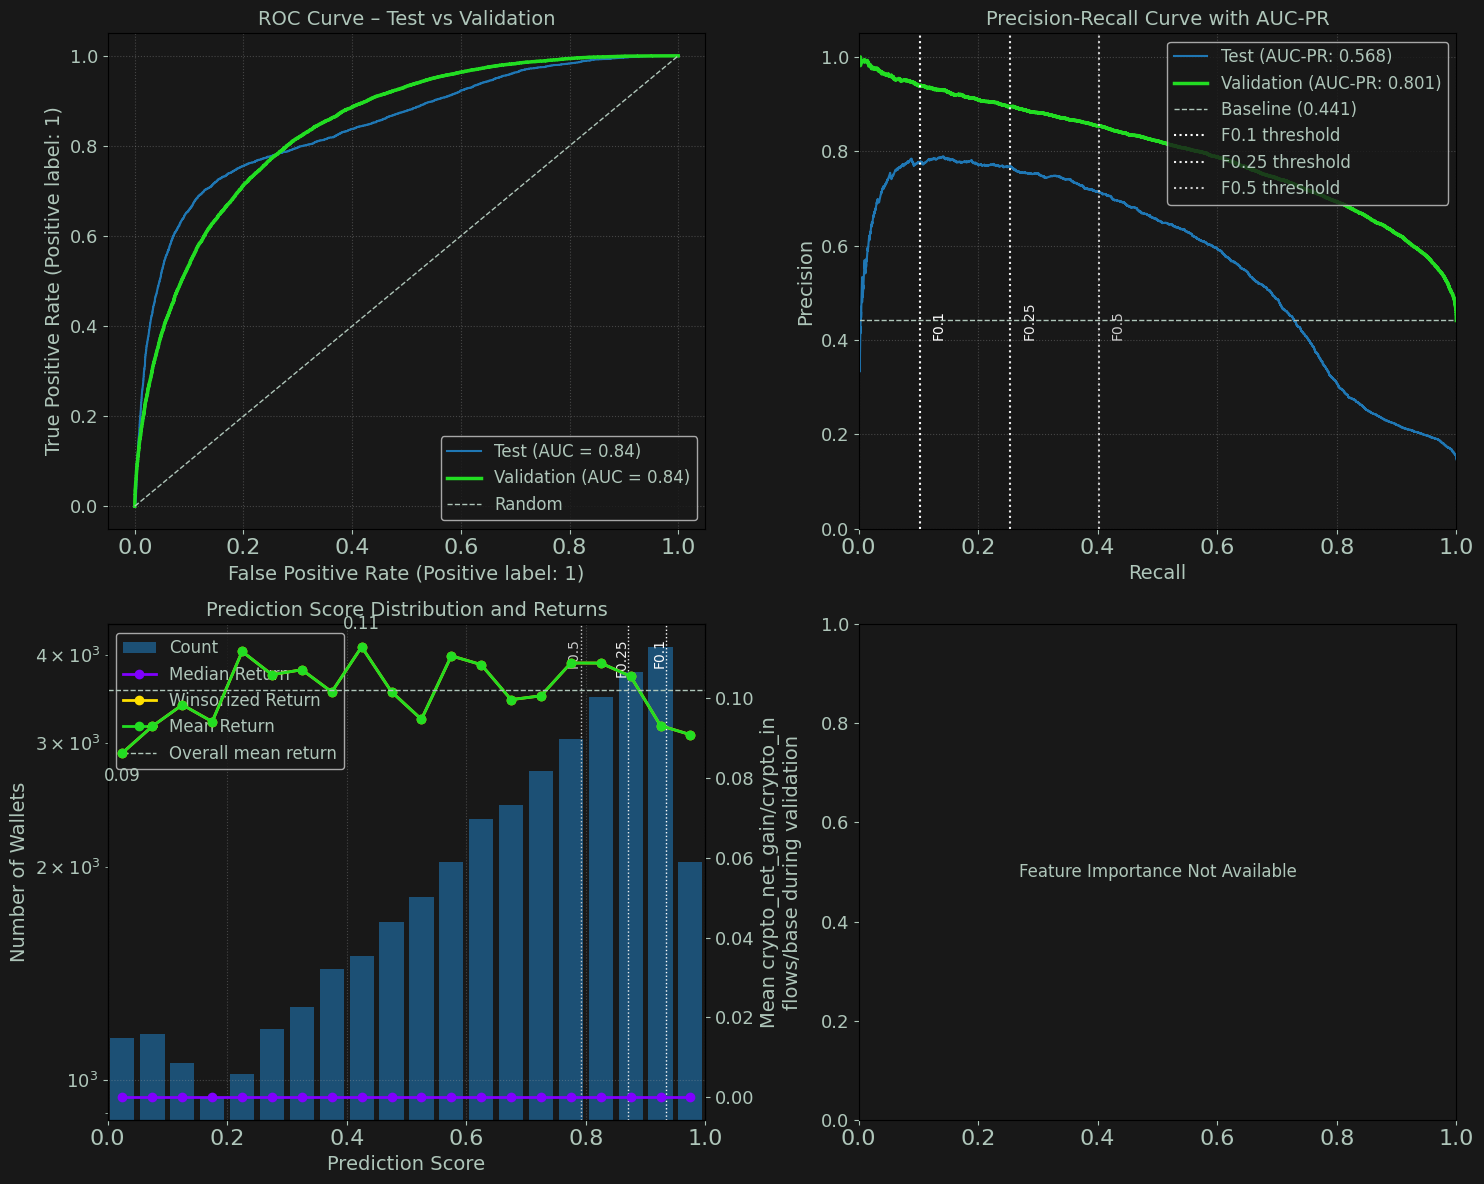

[09/Aug/25 00:21:16] INFO [590987506.<module>:4] 
Performance over 90 days starting 2024-04-05
---------------------------------------------------


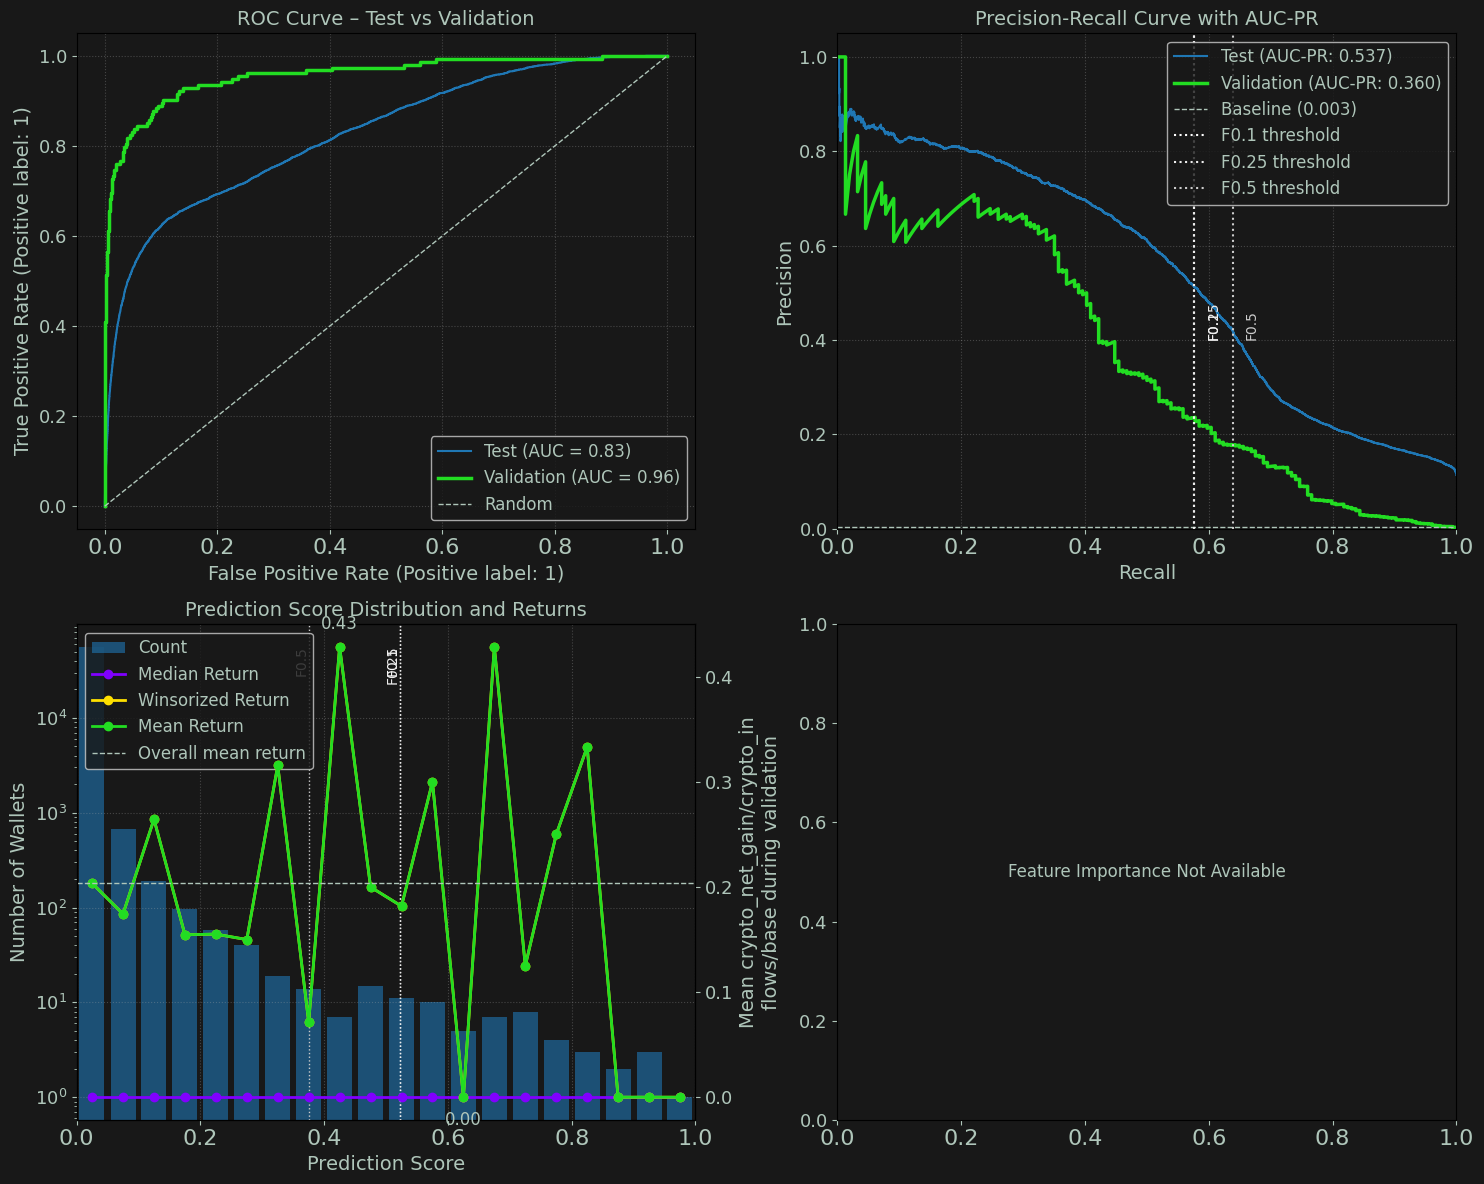

[09/Aug/25 00:21:16] INFO [590987506.<module>:4] 
Performance over 90 days starting 2024-06-04
---------------------------------------------------


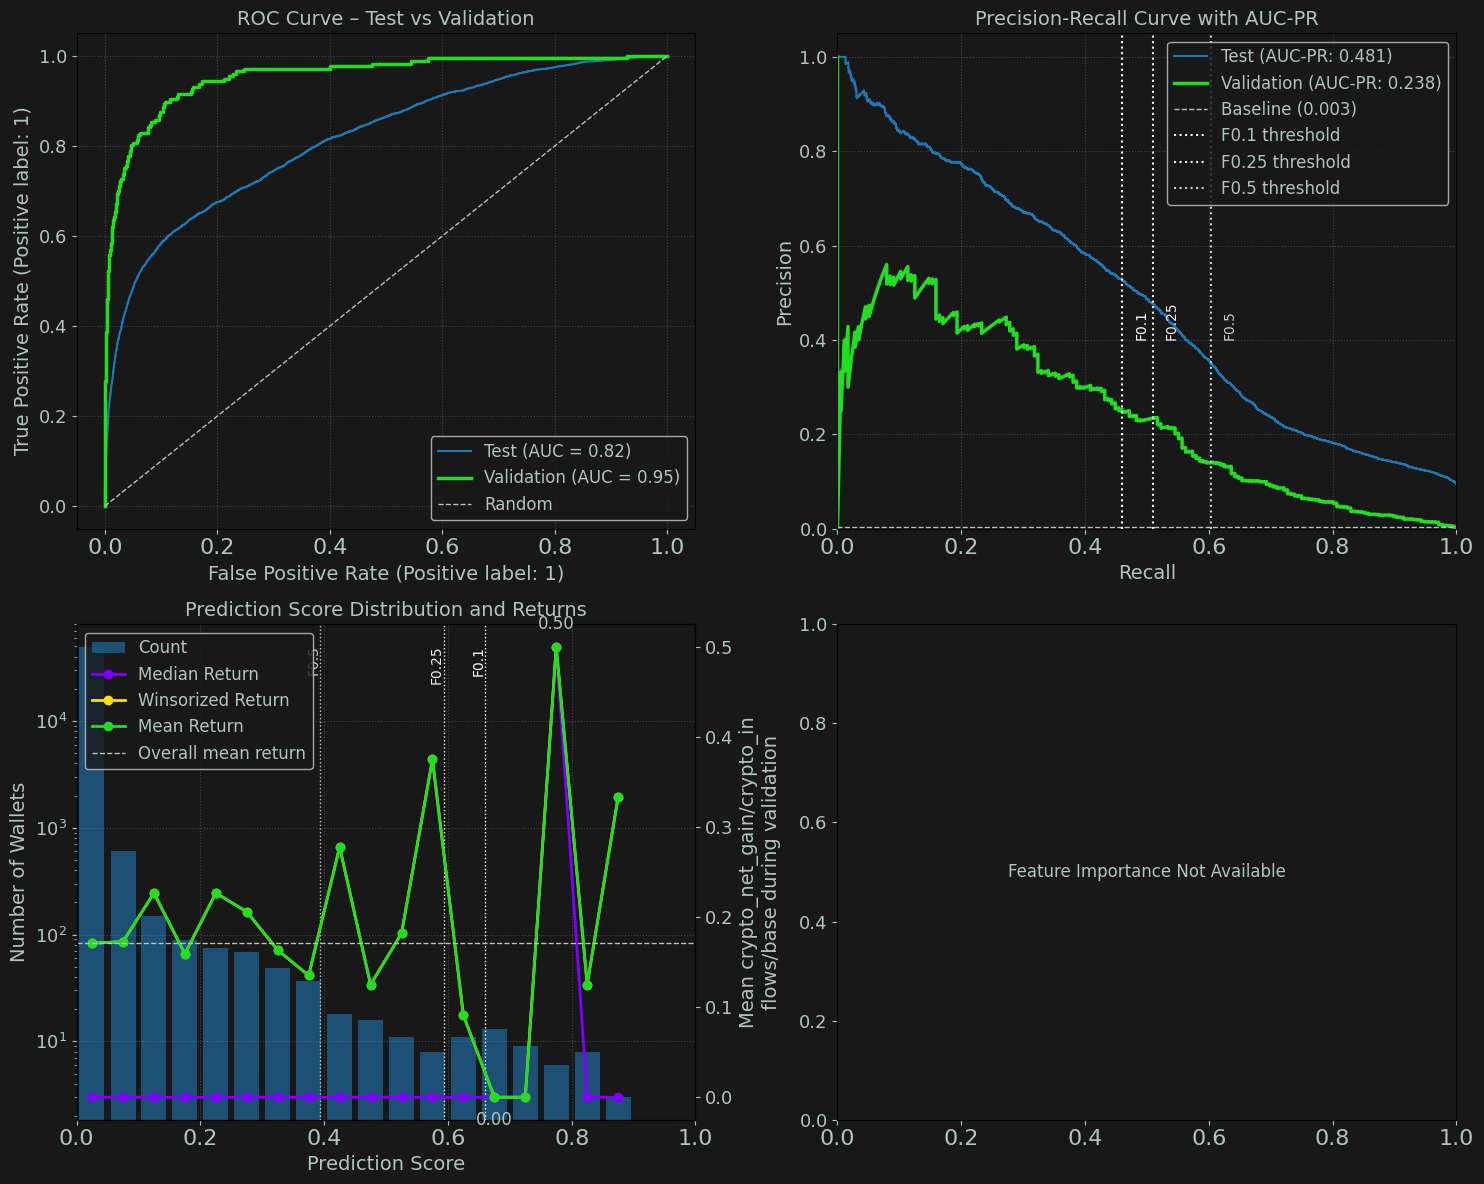

[09/Aug/25 00:21:16] INFO [590987506.<module>:4] 
Performance over 90 days starting 2024-08-03
---------------------------------------------------


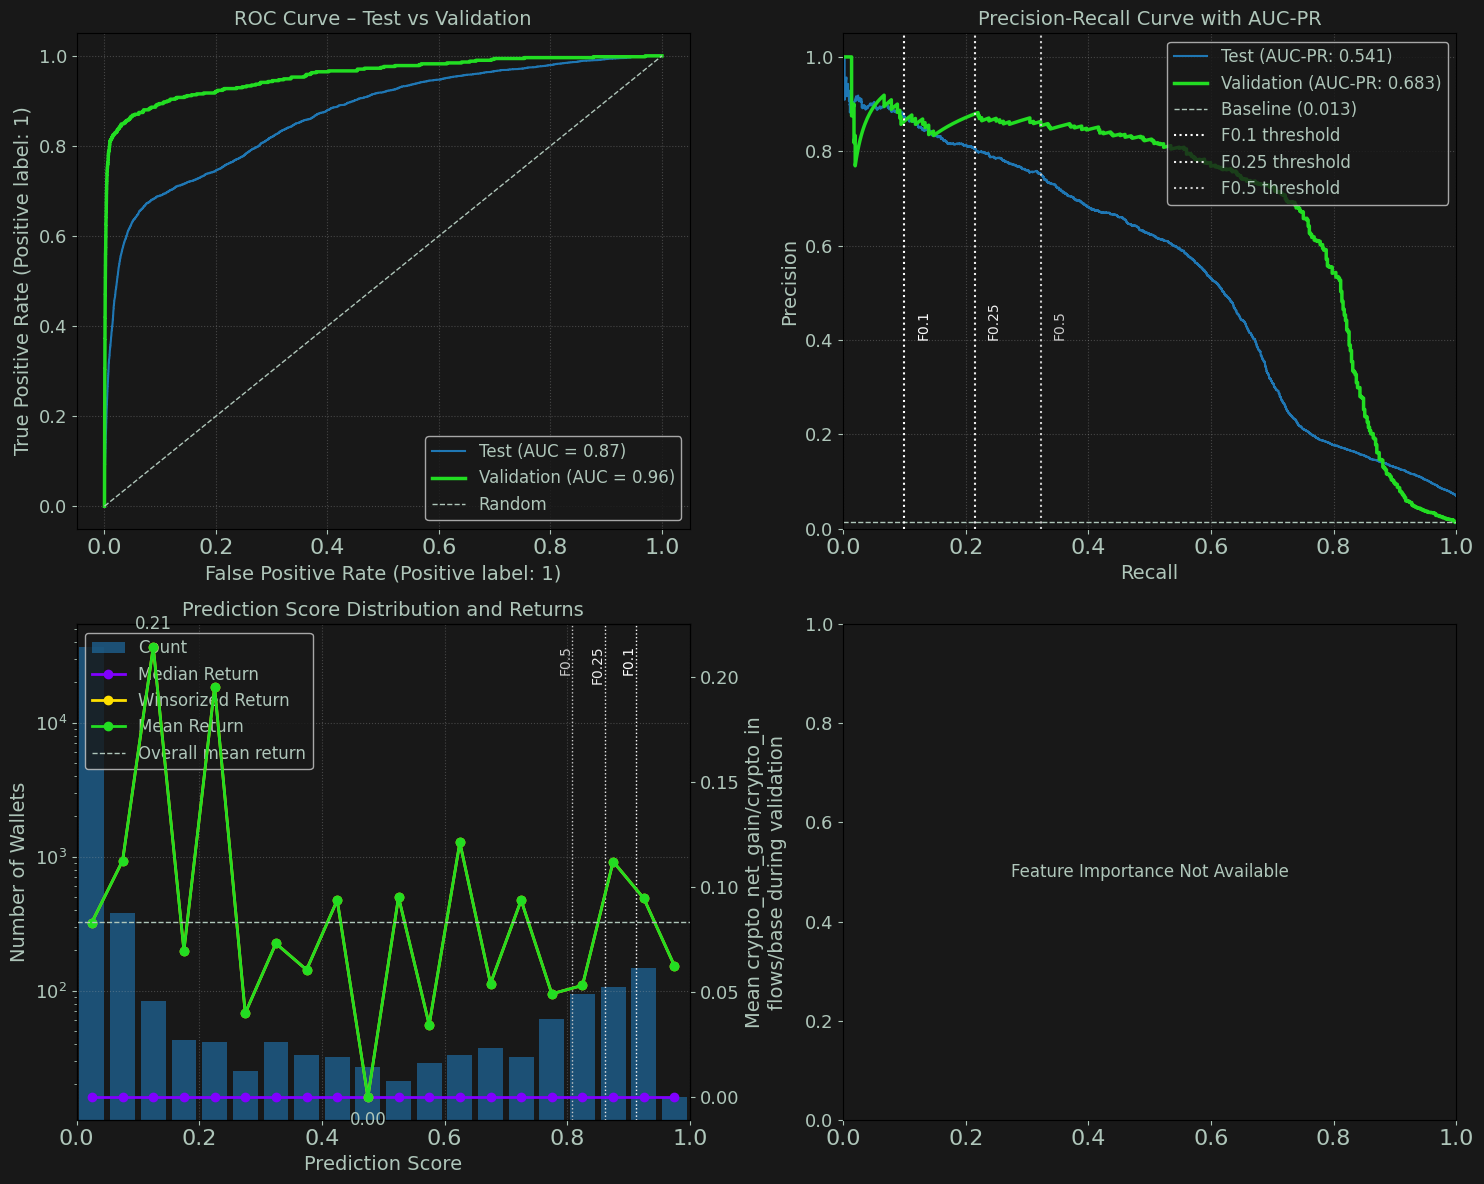

[09/Aug/25 00:21:17] INFO [590987506.<module>:4] 
Performance over 90 days starting 2024-10-02
---------------------------------------------------


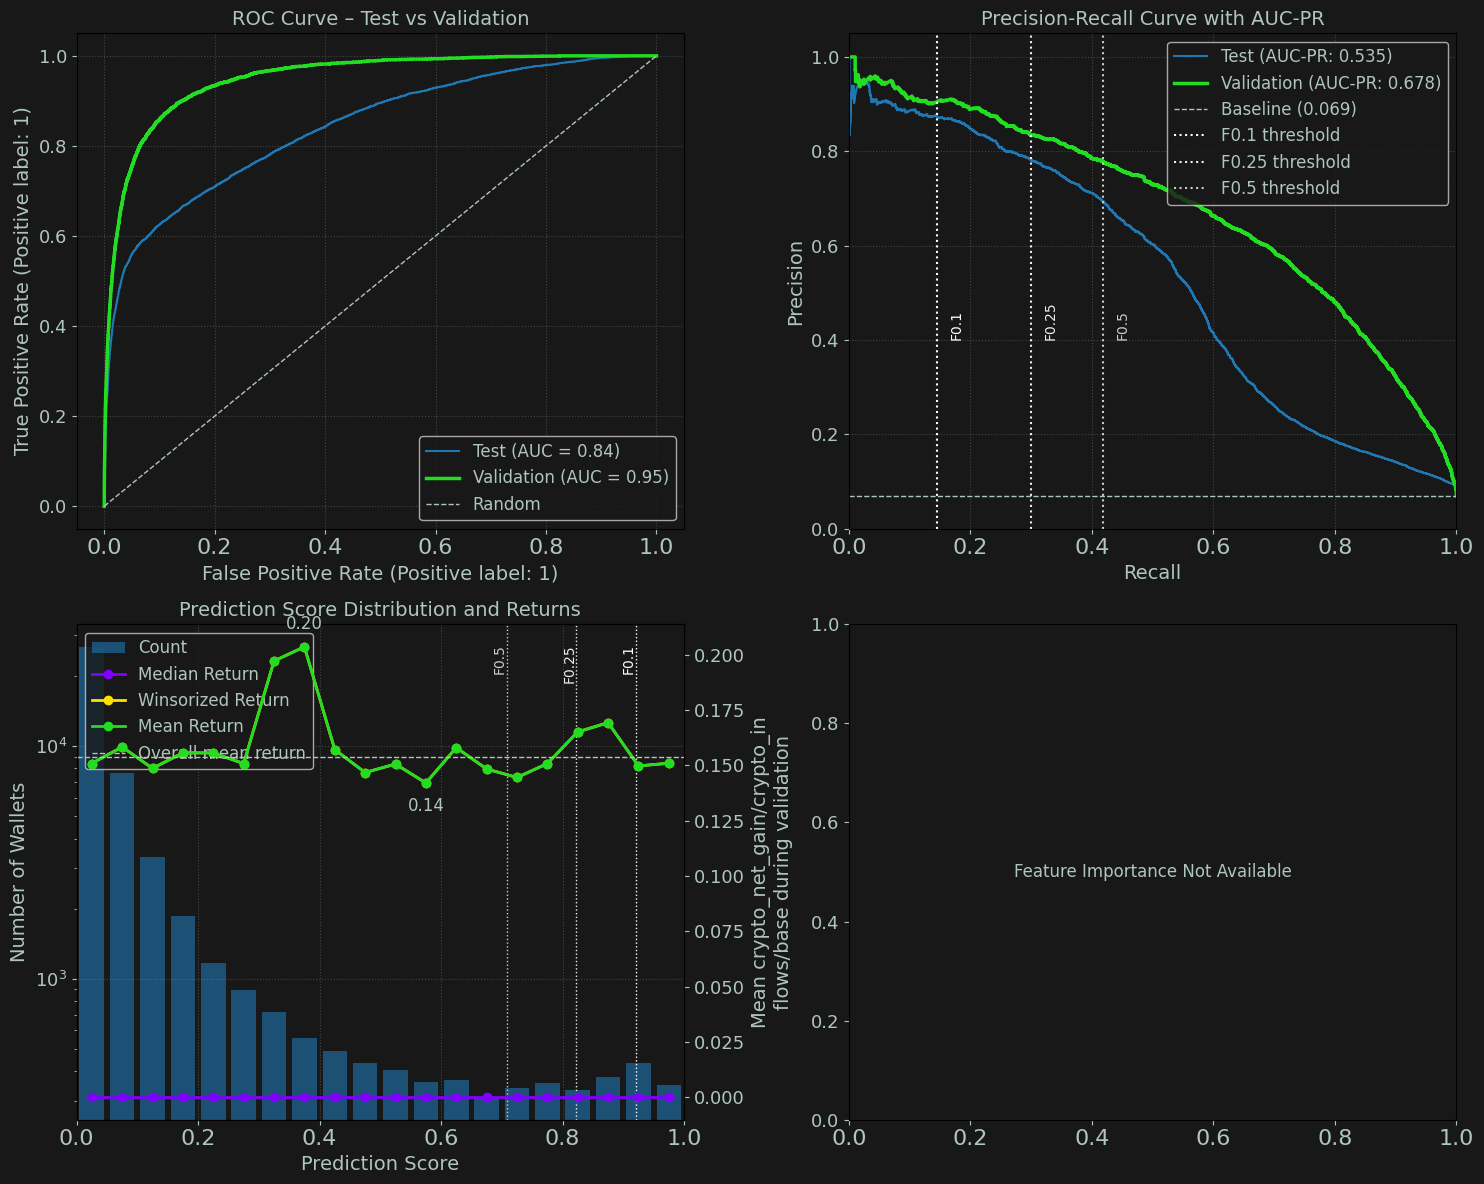

[09/Aug/25 00:21:17] INFO [590987506.<module>:4] 
Performance over 90 days starting 2024-12-01
---------------------------------------------------


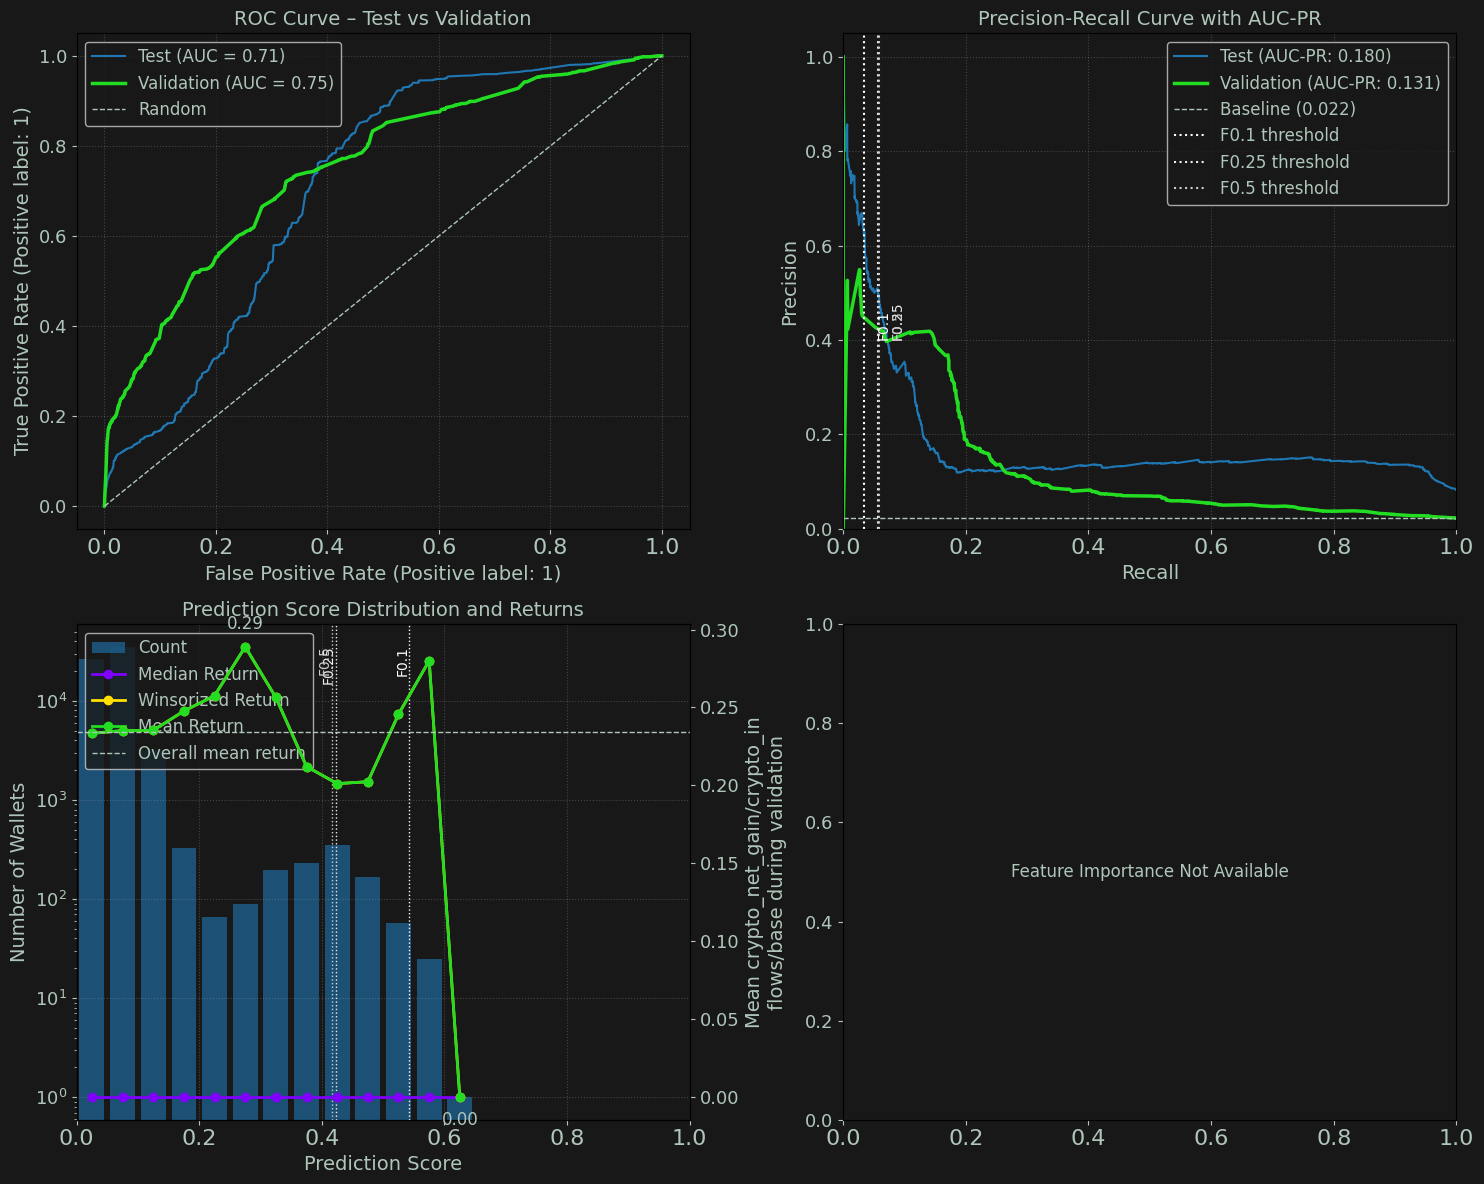

[09/Aug/25 00:21:18] INFO [590987506.<module>:4] 
Performance over 90 days starting 2025-01-30
---------------------------------------------------


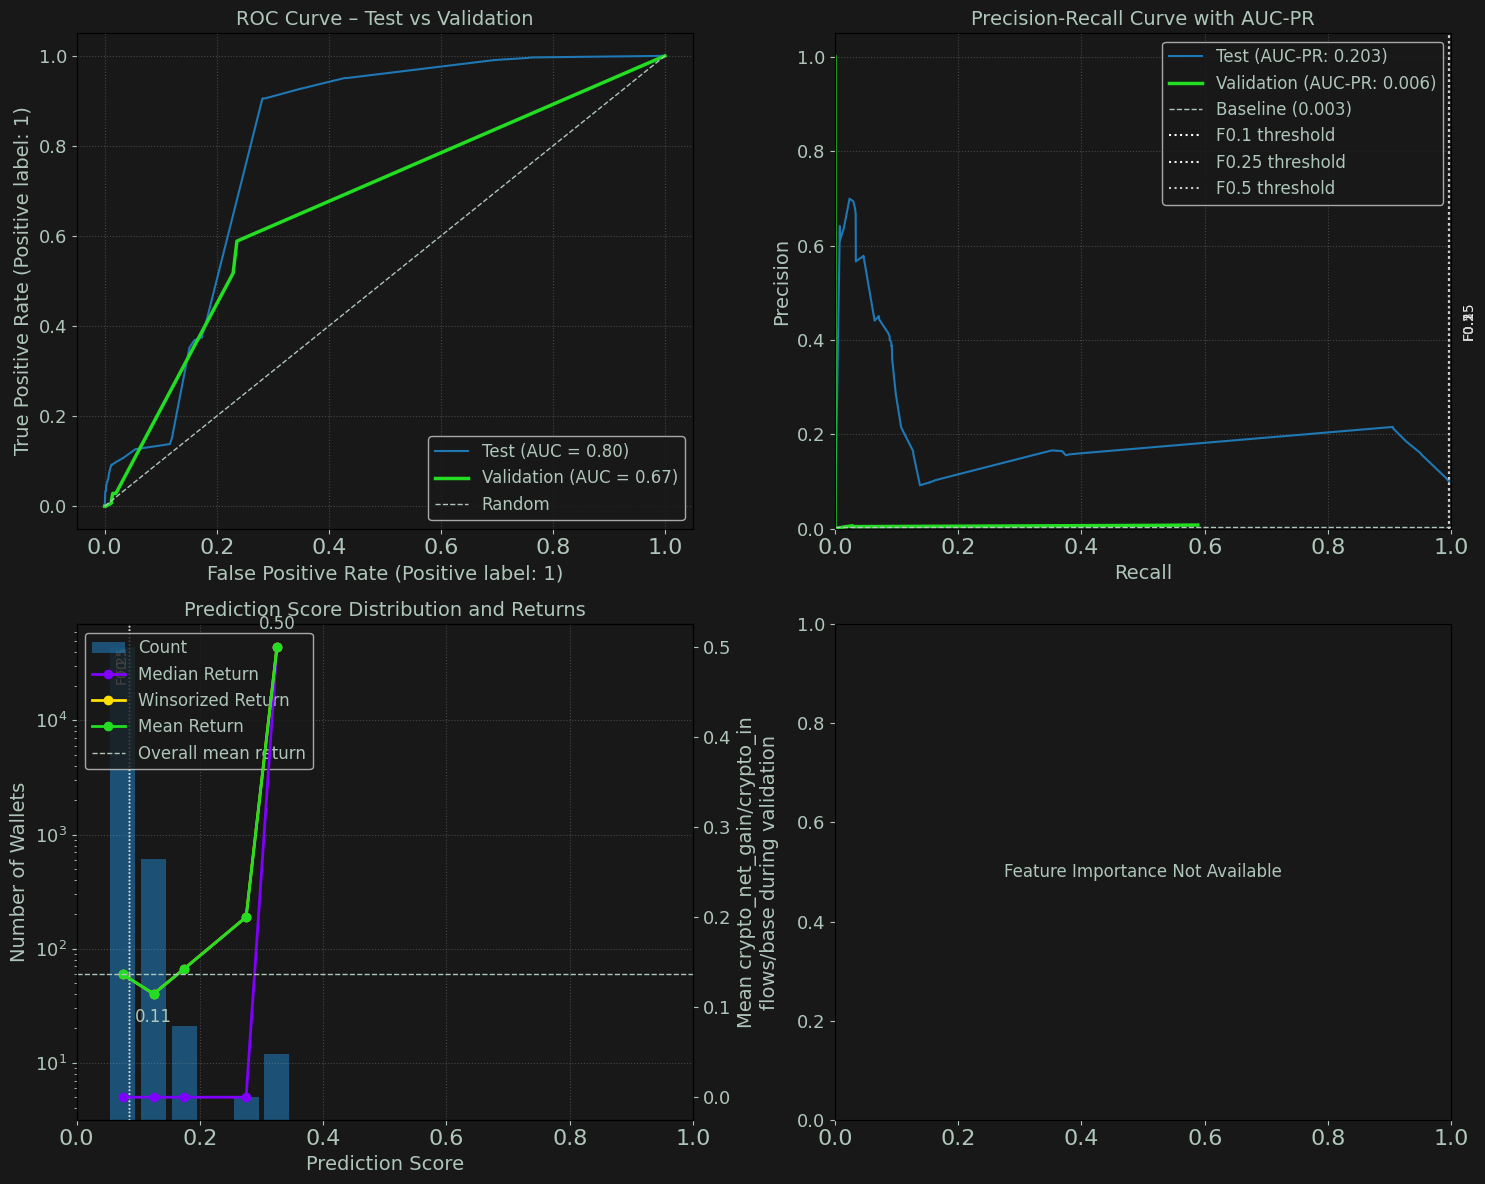

[09/Aug/25 00:21:18] INFO [590987506.<module>:4] 
Performance over 90 days starting 2025-03-31
---------------------------------------------------


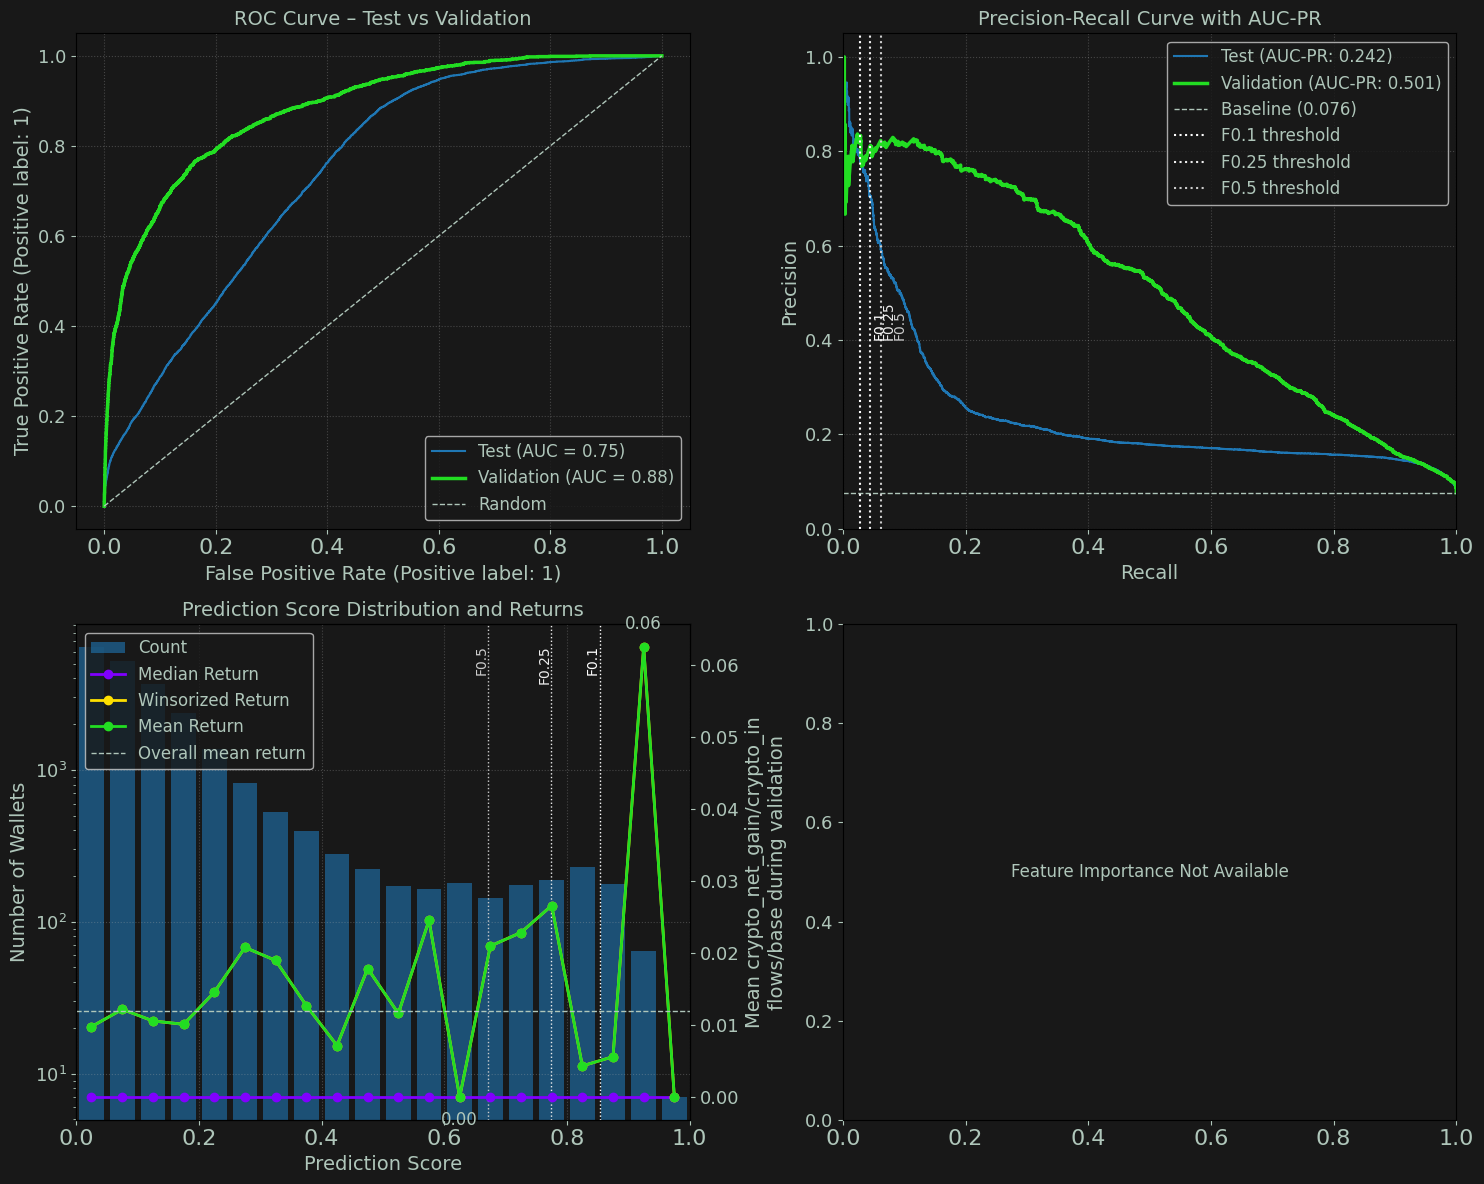

In [19]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    try:
        evaluators[e].plot_wallet_evaluation()
    except:
        continue
    # evaluators[e].summary_report()


[08/Aug/25 22:43:09] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-08-03
---------------------------------------------------


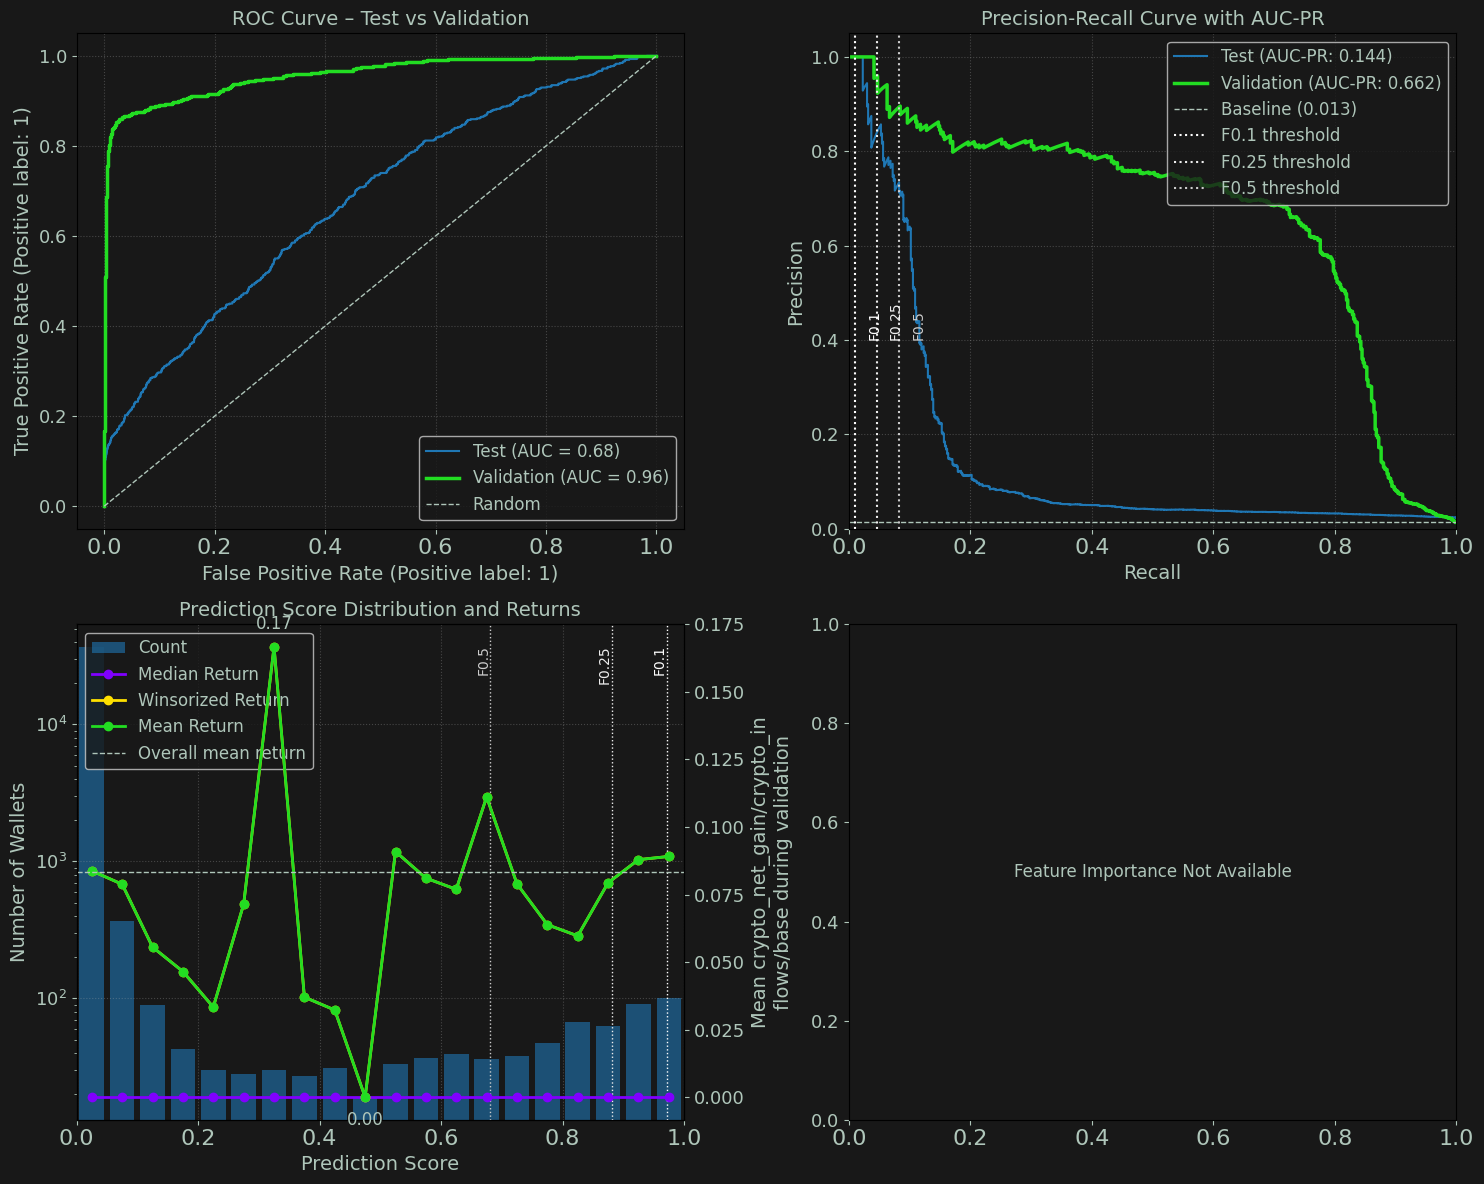

[08/Aug/25 22:43:09] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-10-02
---------------------------------------------------


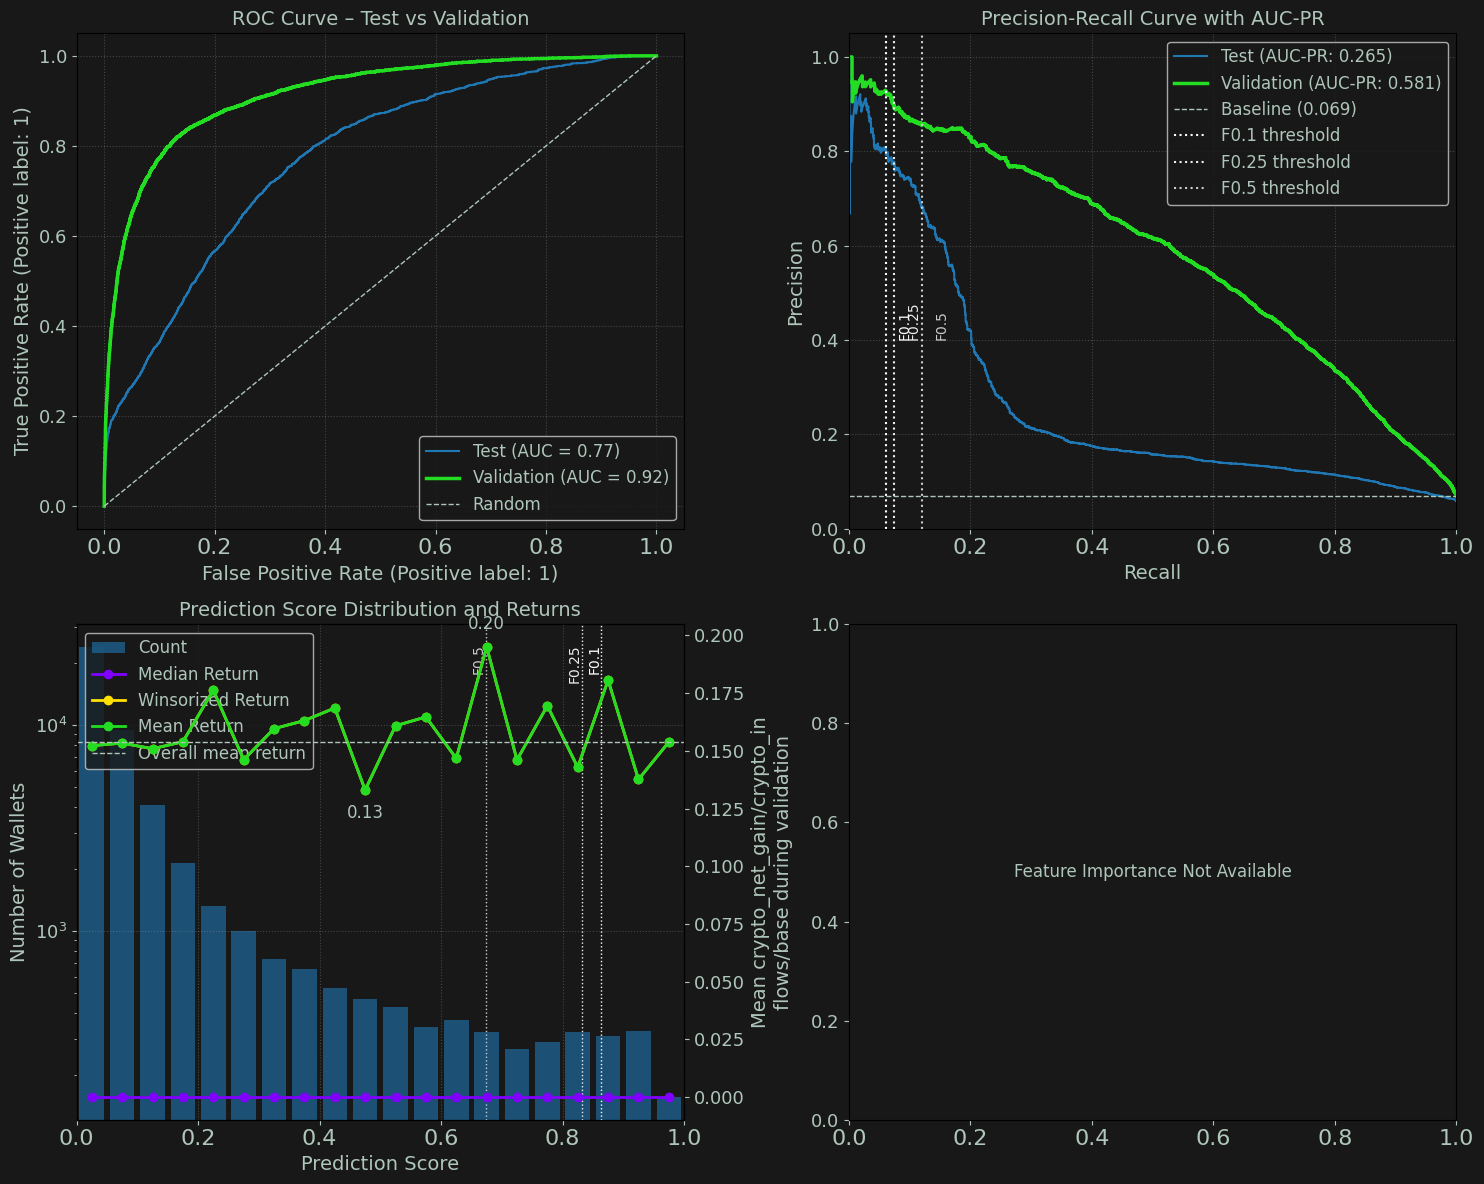

[08/Aug/25 22:43:10] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-12-01
---------------------------------------------------


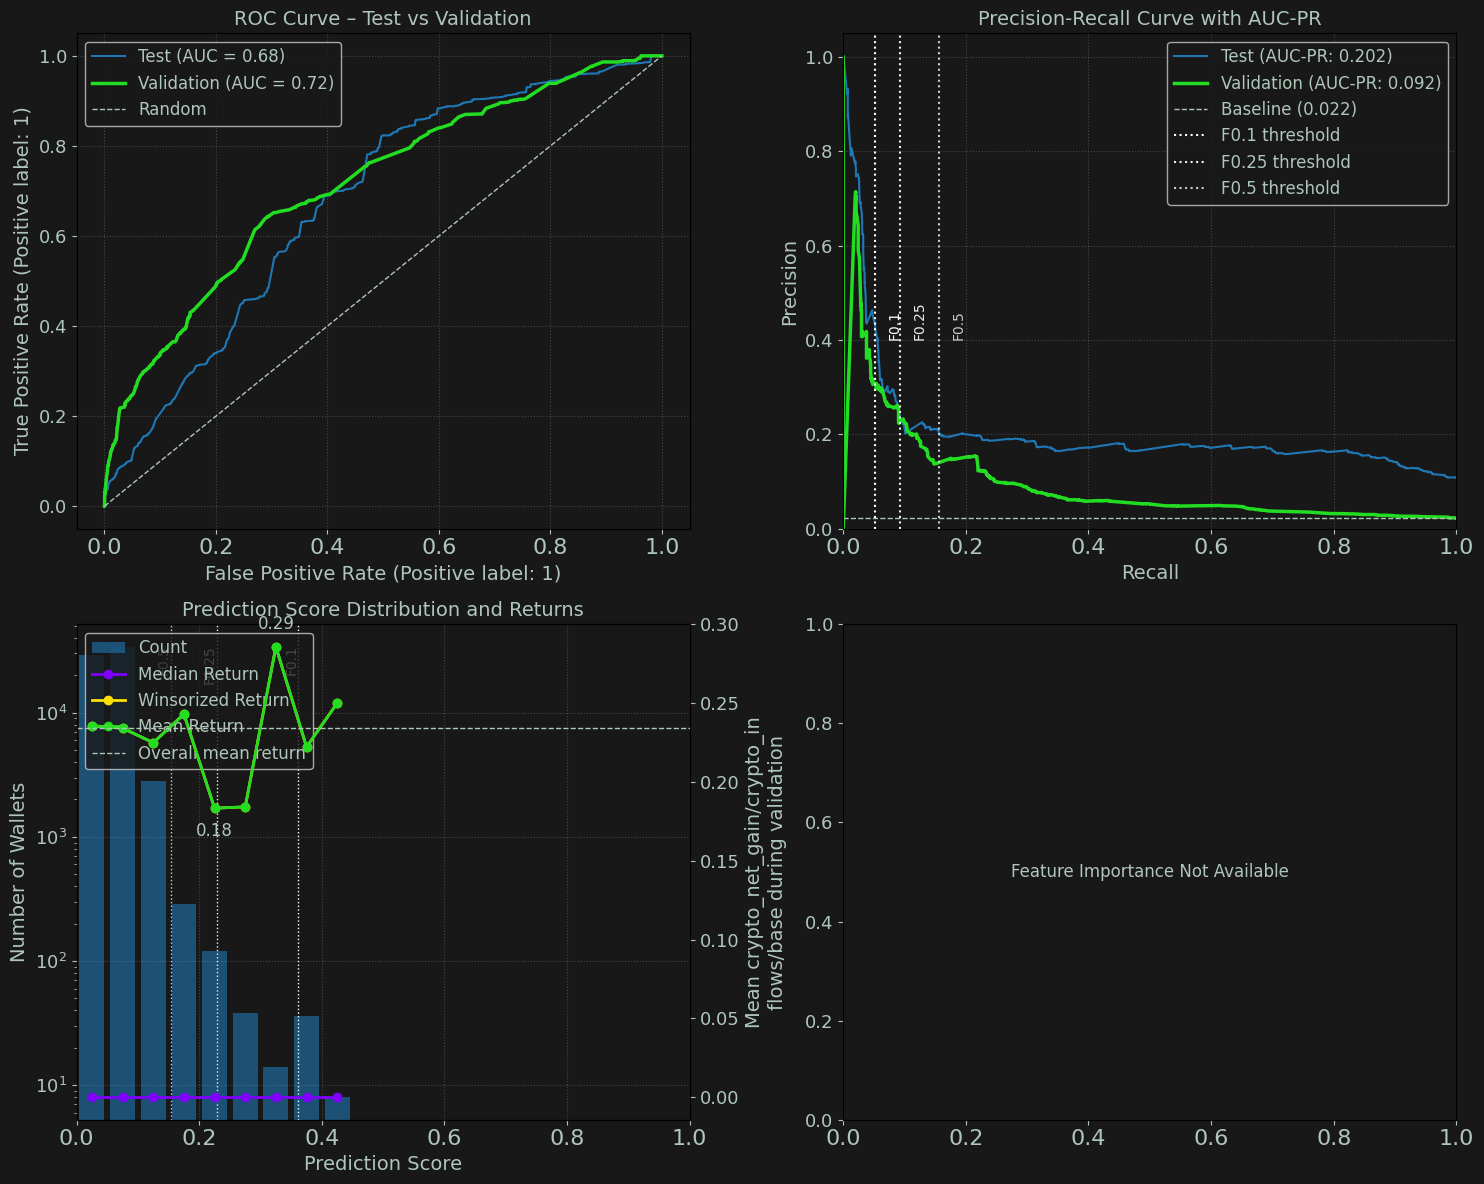

[08/Aug/25 22:43:10] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2025-01-30
---------------------------------------------------


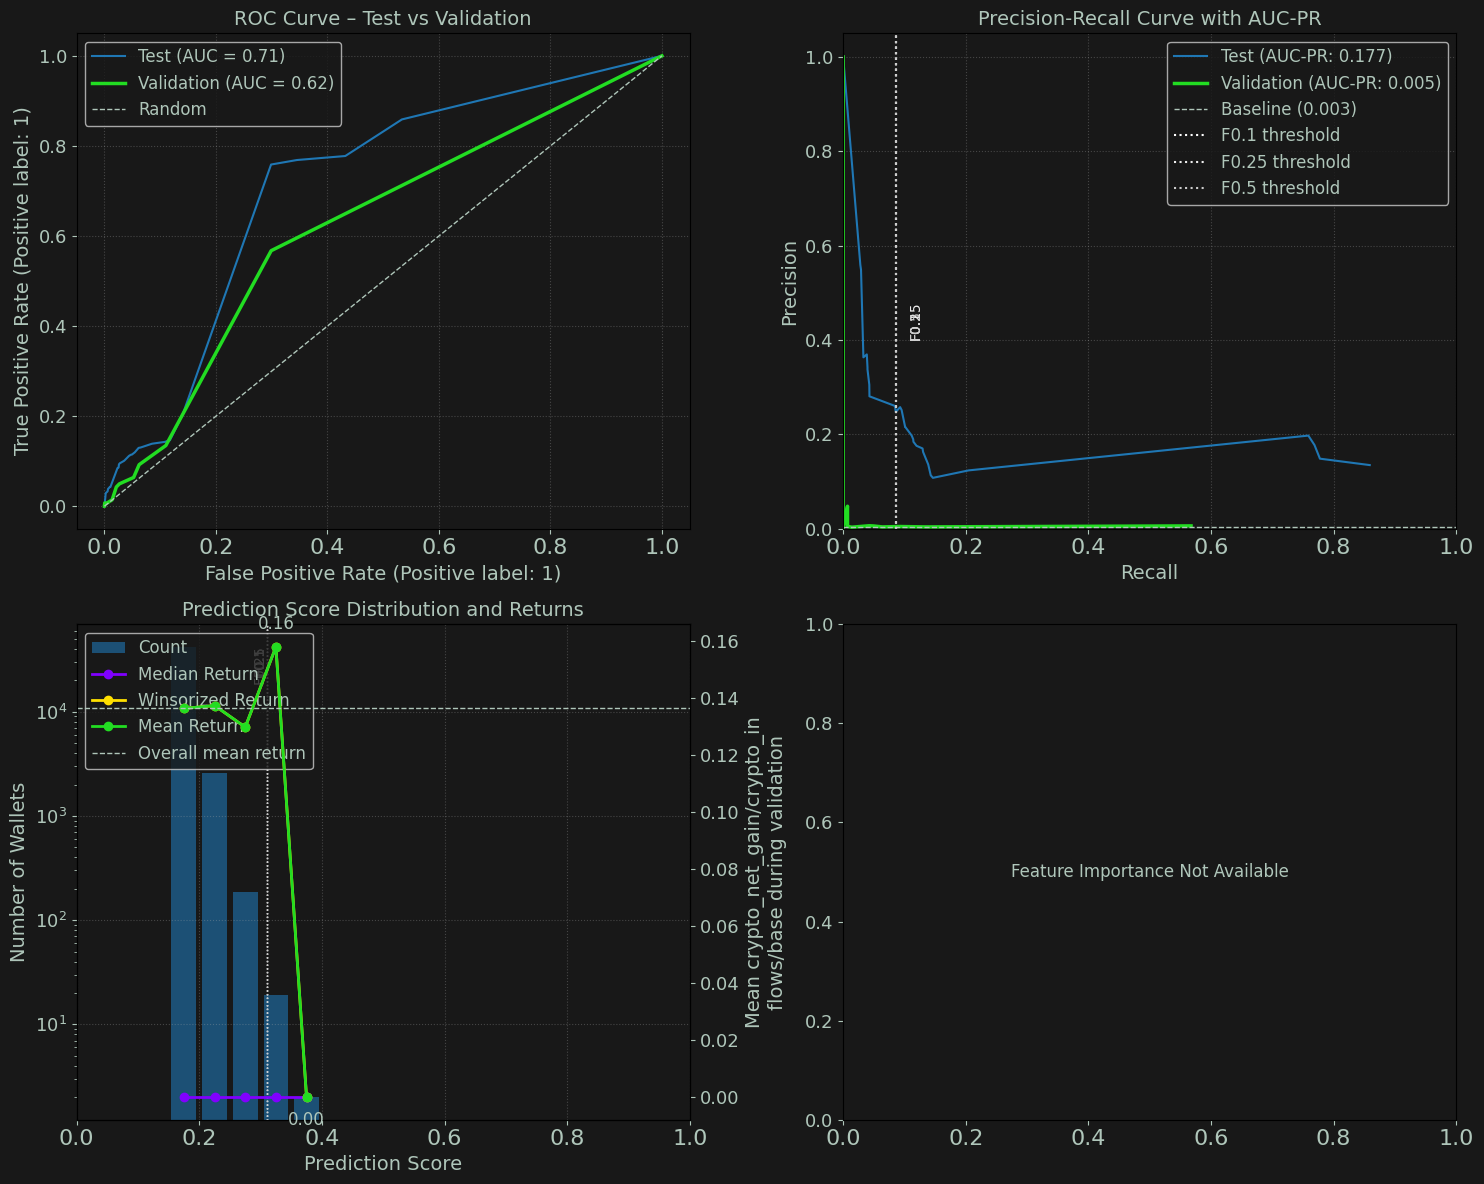

[08/Aug/25 22:43:10] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2025-03-31
---------------------------------------------------


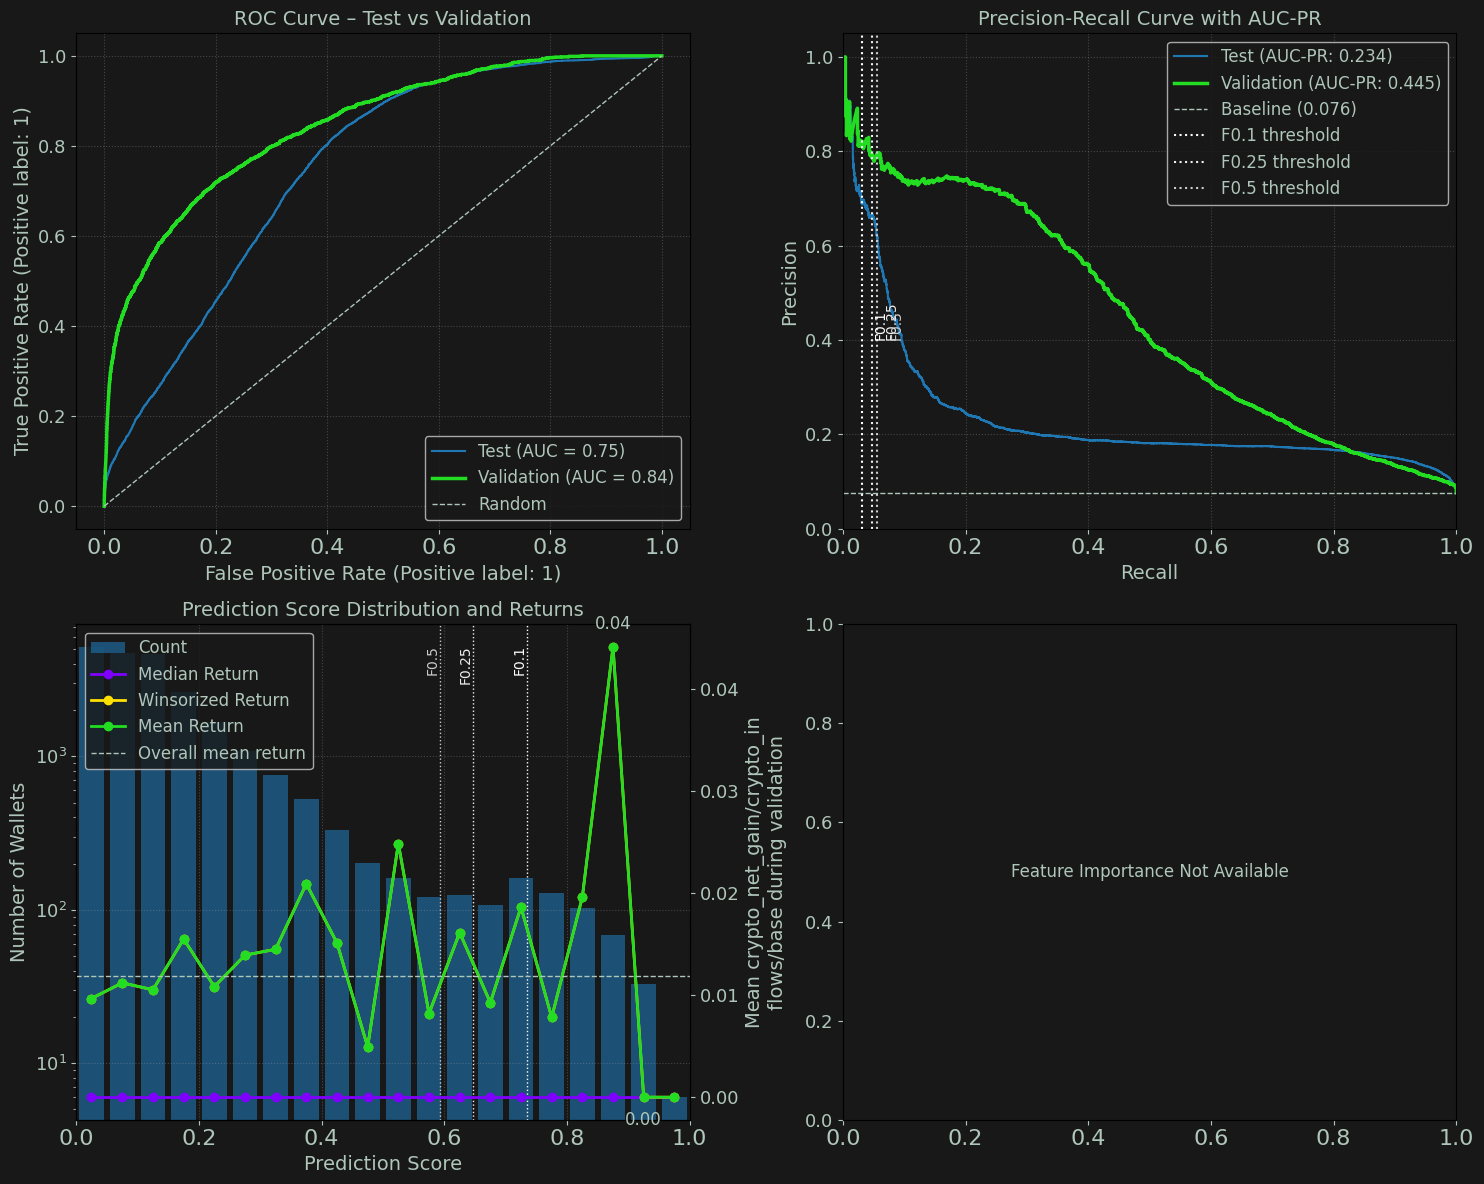

In [14]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    evaluators[e].plot_wallet_evaluation()
    # evaluators[e].summary_report()


In [97]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    # evaluators[e].plot_wallet_evaluation()
    evaluators[e].summary_report()


[08/Aug/25 21:41:46] INFO [39274534.<module>:4] 
Performance over 90 days starting 2023-12-07
---------------------------------------------------
[08/Aug/25 21:41:46] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base 0.4 to 
ID: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-120/wscr-dda-951--sh-120-0808-201711/output/model.tar.gz
Test Samples:             4,732
Val Positive Samples:     382 (1.2%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.668  |  0.832
Val Accuracy:               0.985  |  0.970
Val Precision:              0.037  |  0.481
Val Recall:                 0.008  |  0.188
Val F1 Score:               0.013  |  0.271

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |    n/a |   0.012 |   0.012

[08/Aug/25 21:47:11] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2023-12-07
---------------------------------------------------


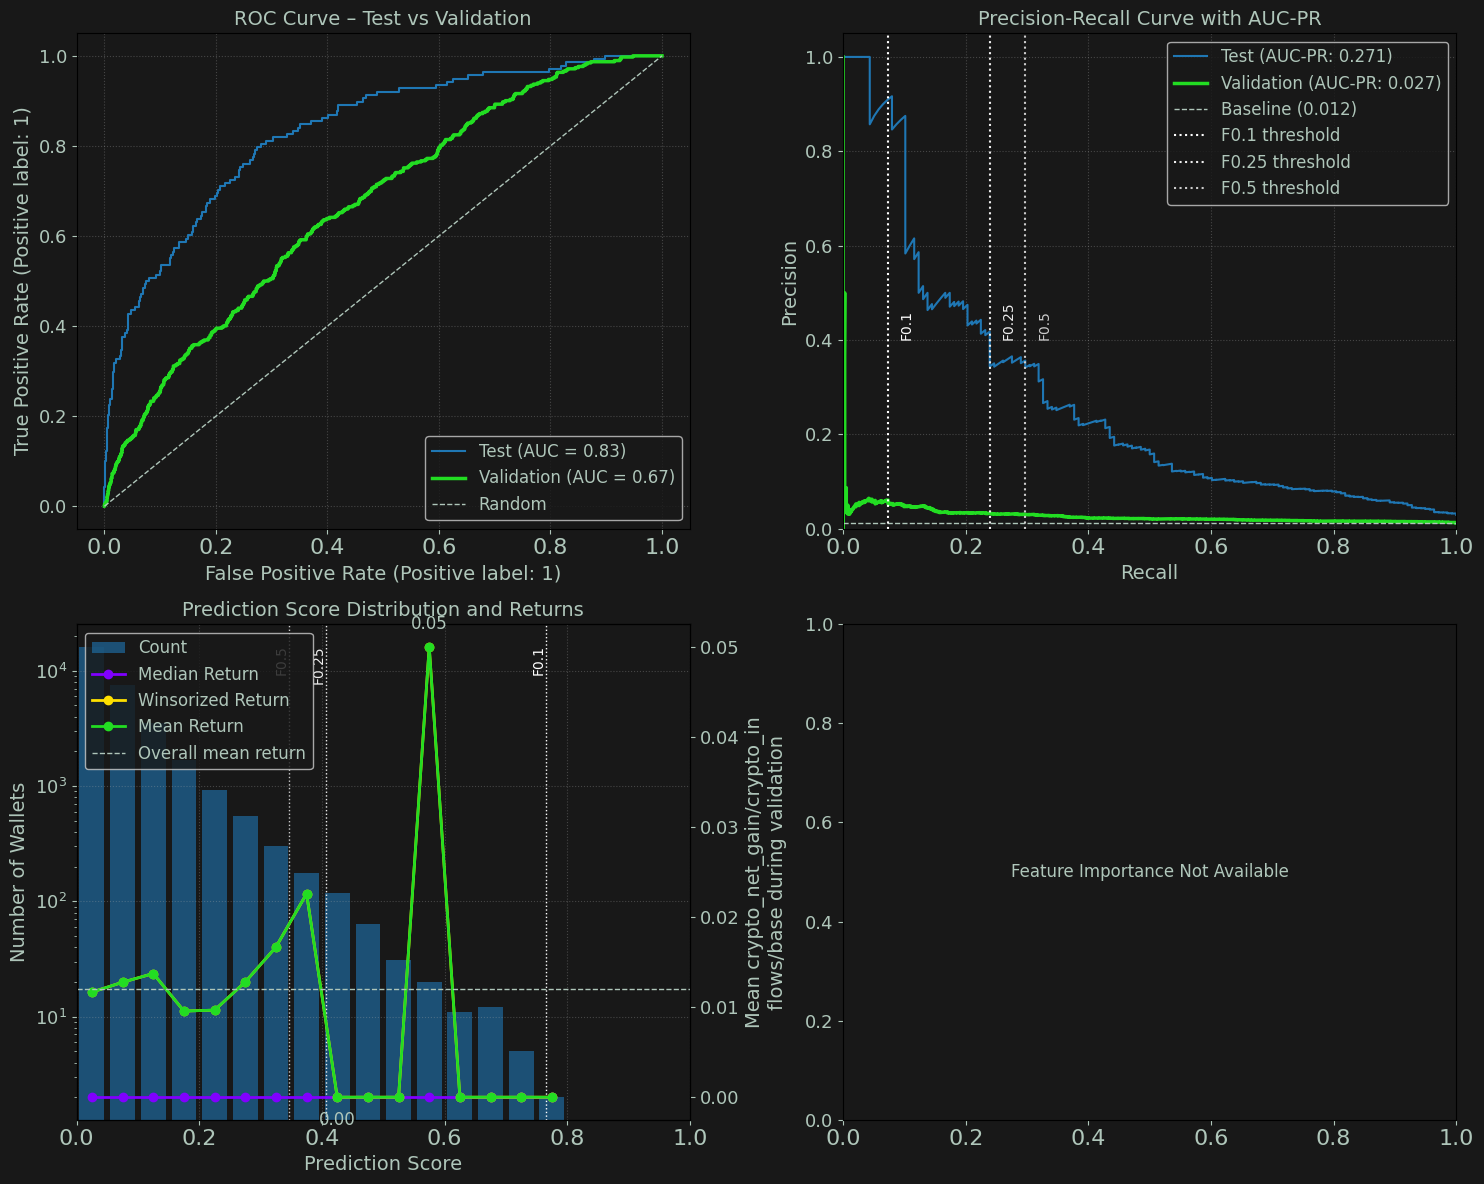

[08/Aug/25 21:47:12] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-02-05
---------------------------------------------------


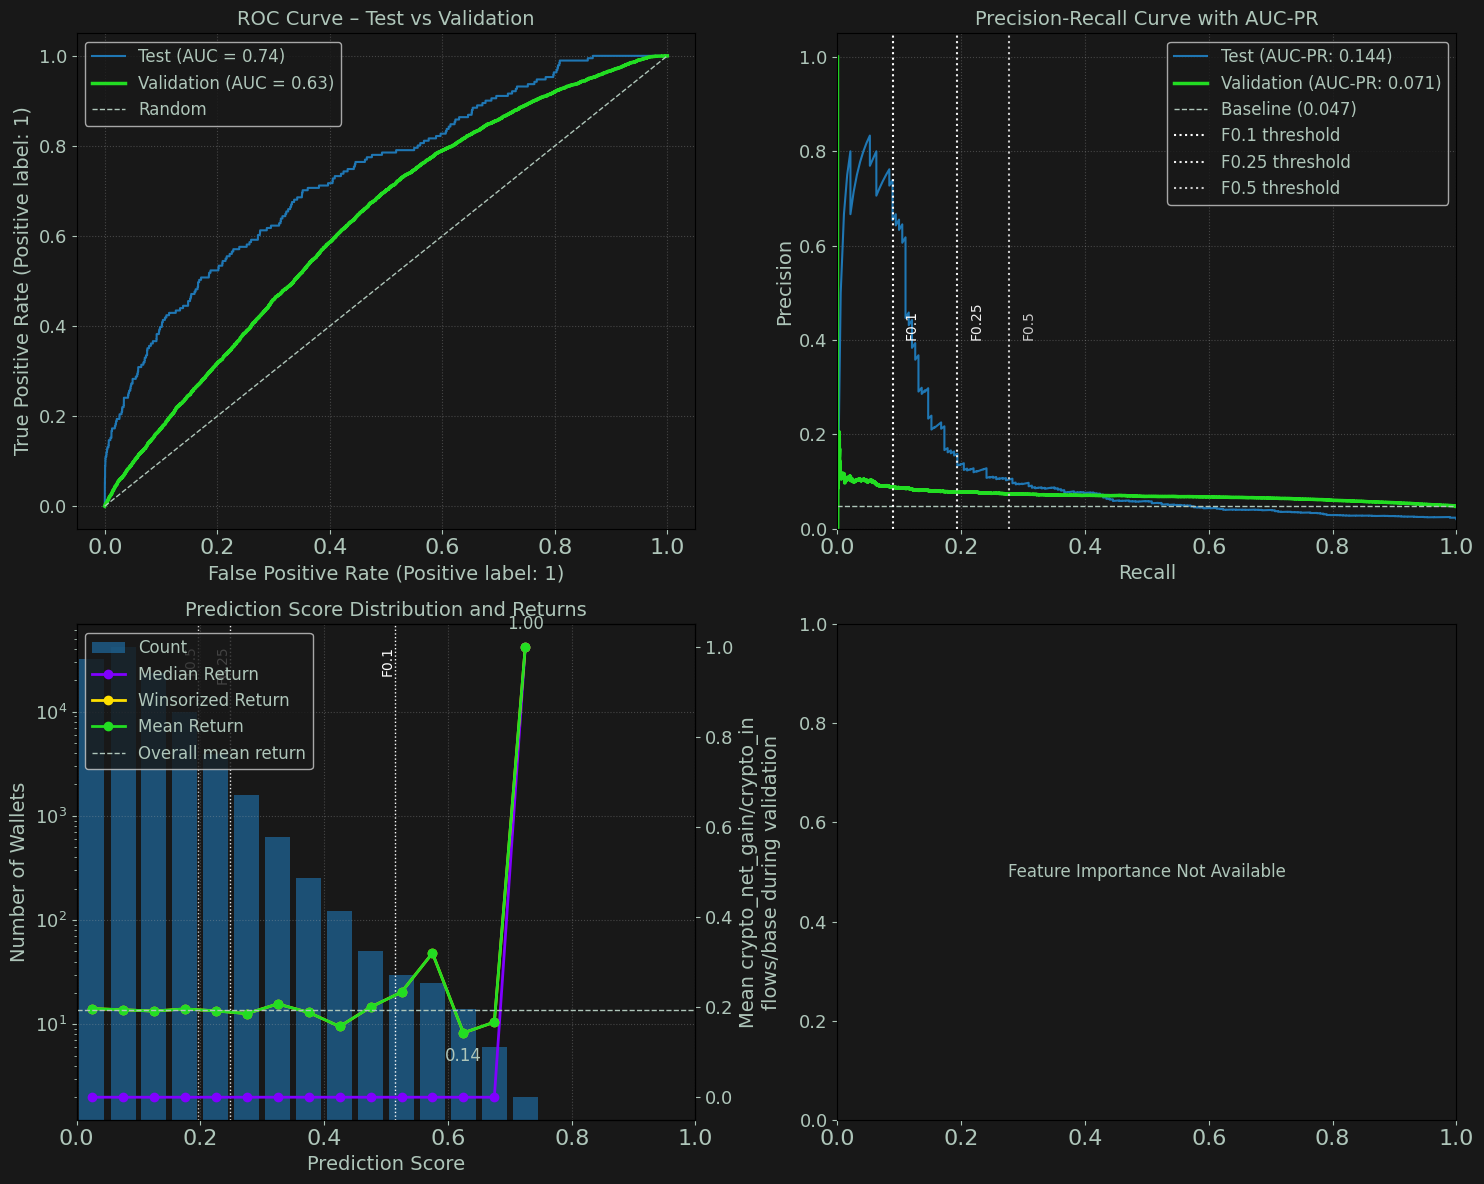

[08/Aug/25 21:47:12] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-04-05
---------------------------------------------------


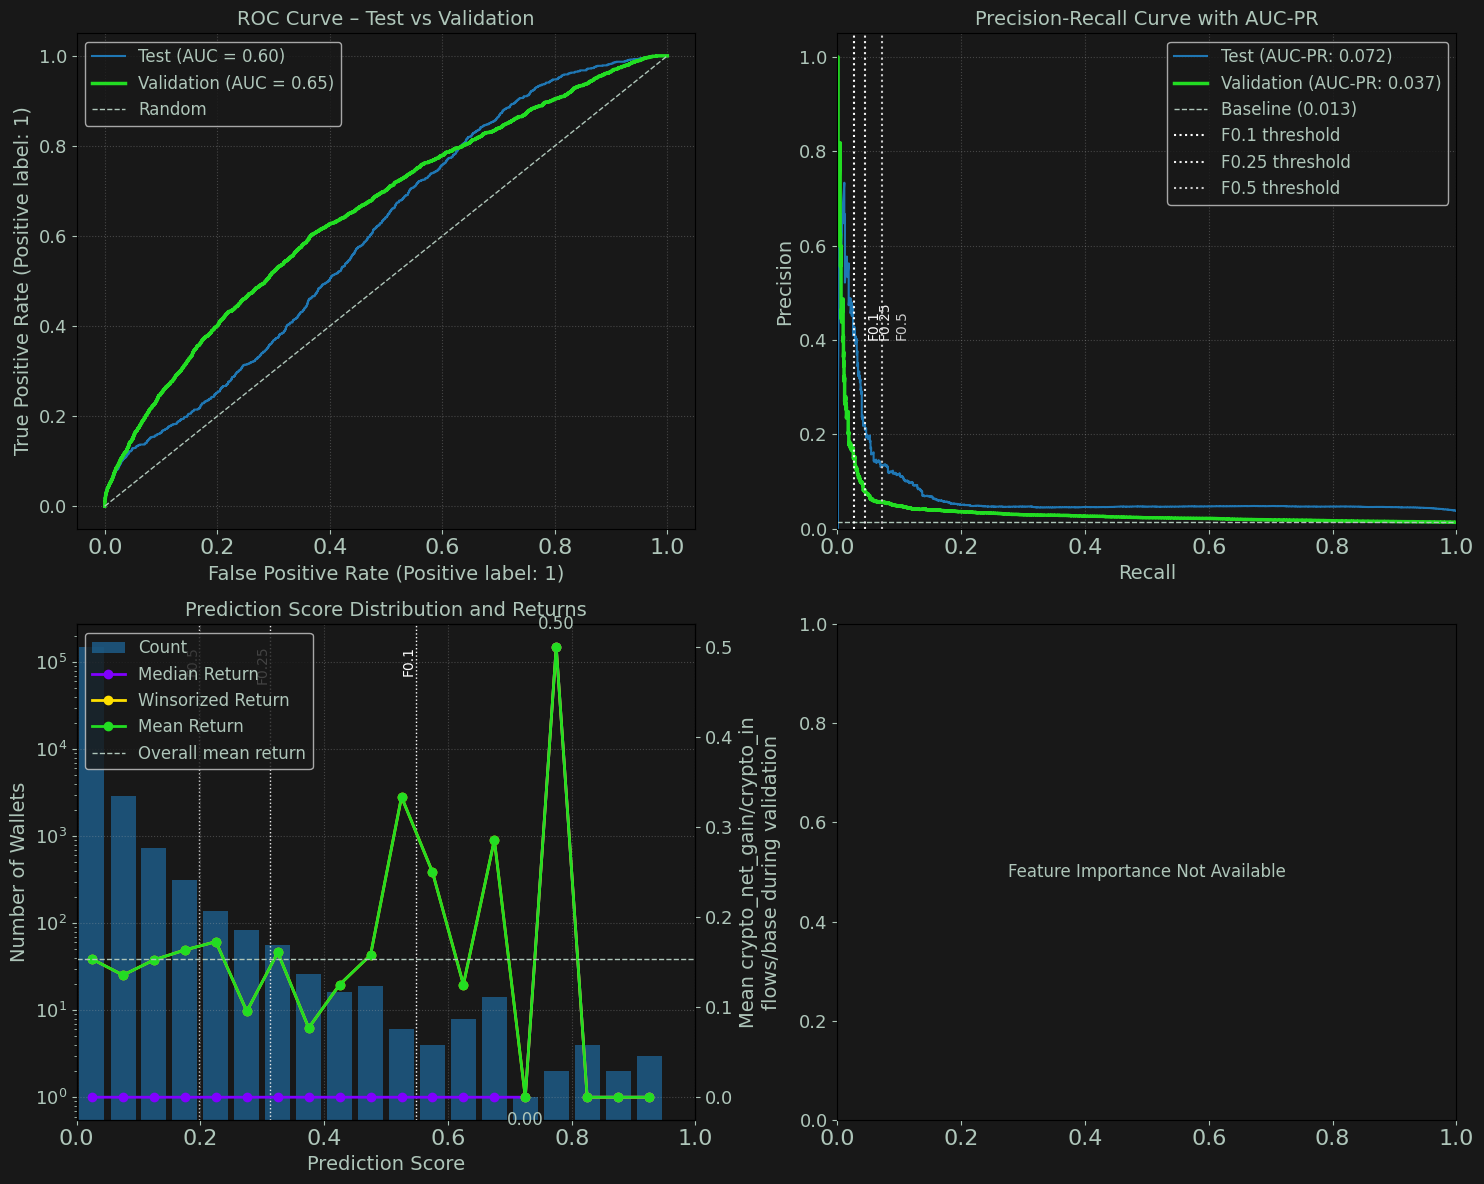

[08/Aug/25 21:47:13] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-06-04
---------------------------------------------------


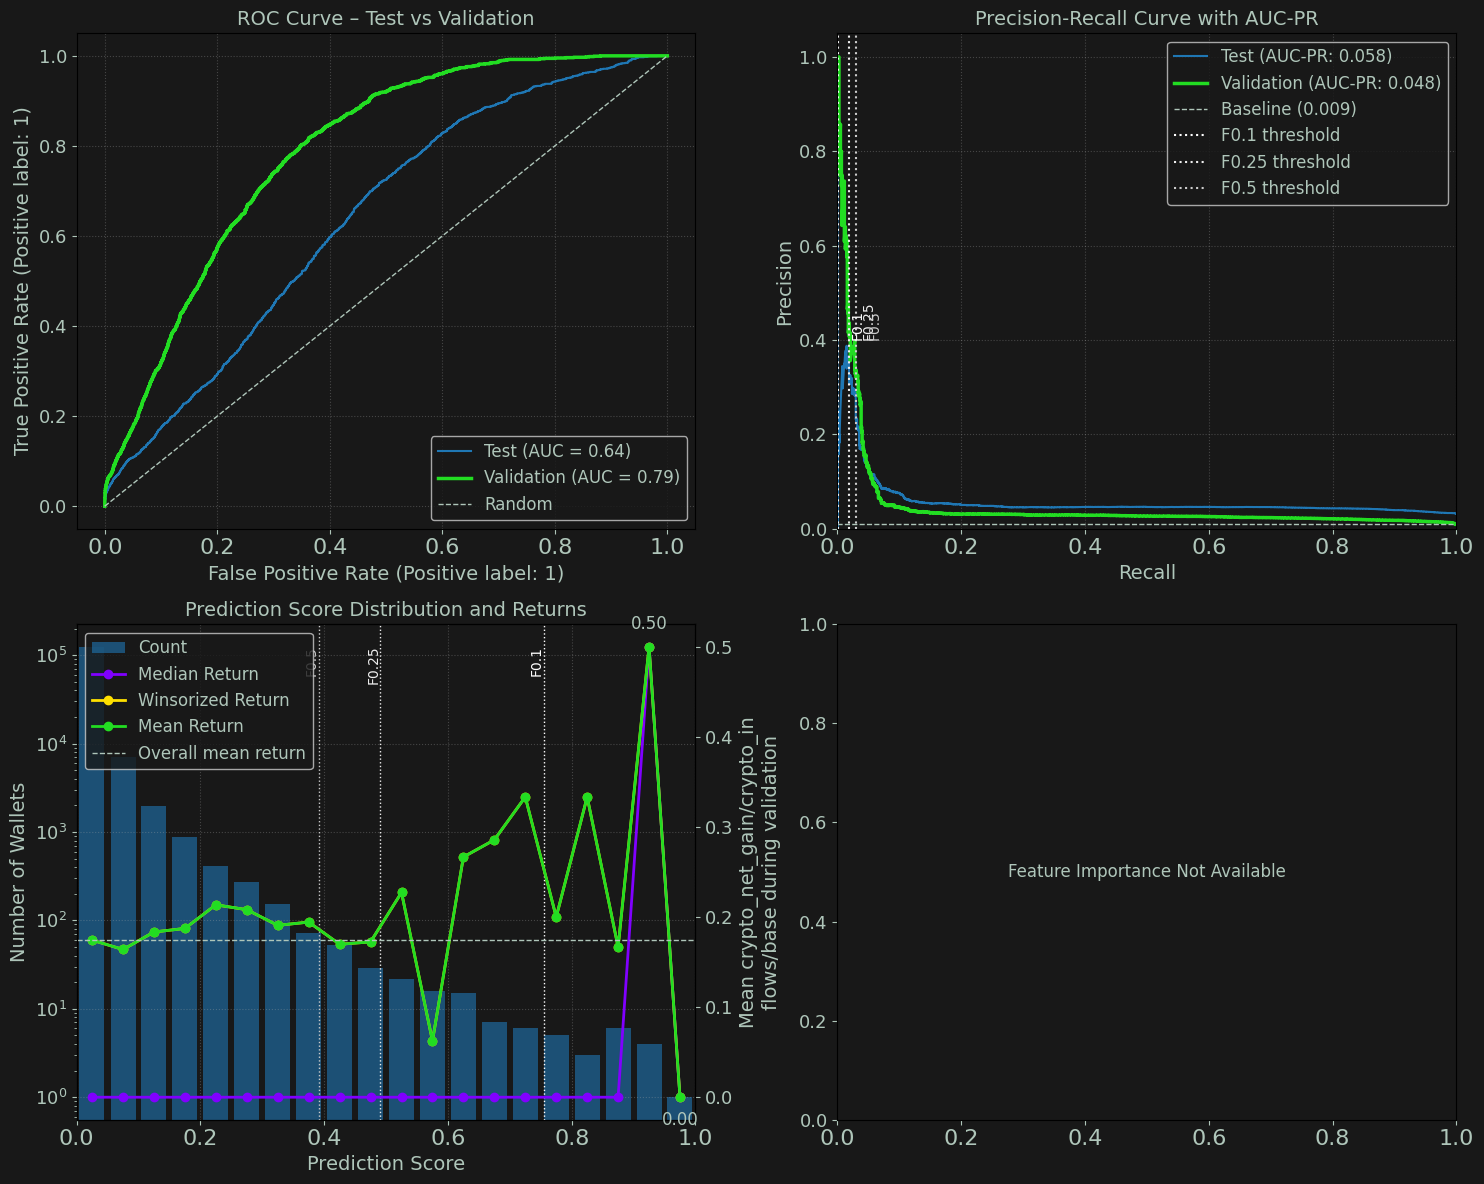

[08/Aug/25 21:47:14] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-08-03
---------------------------------------------------


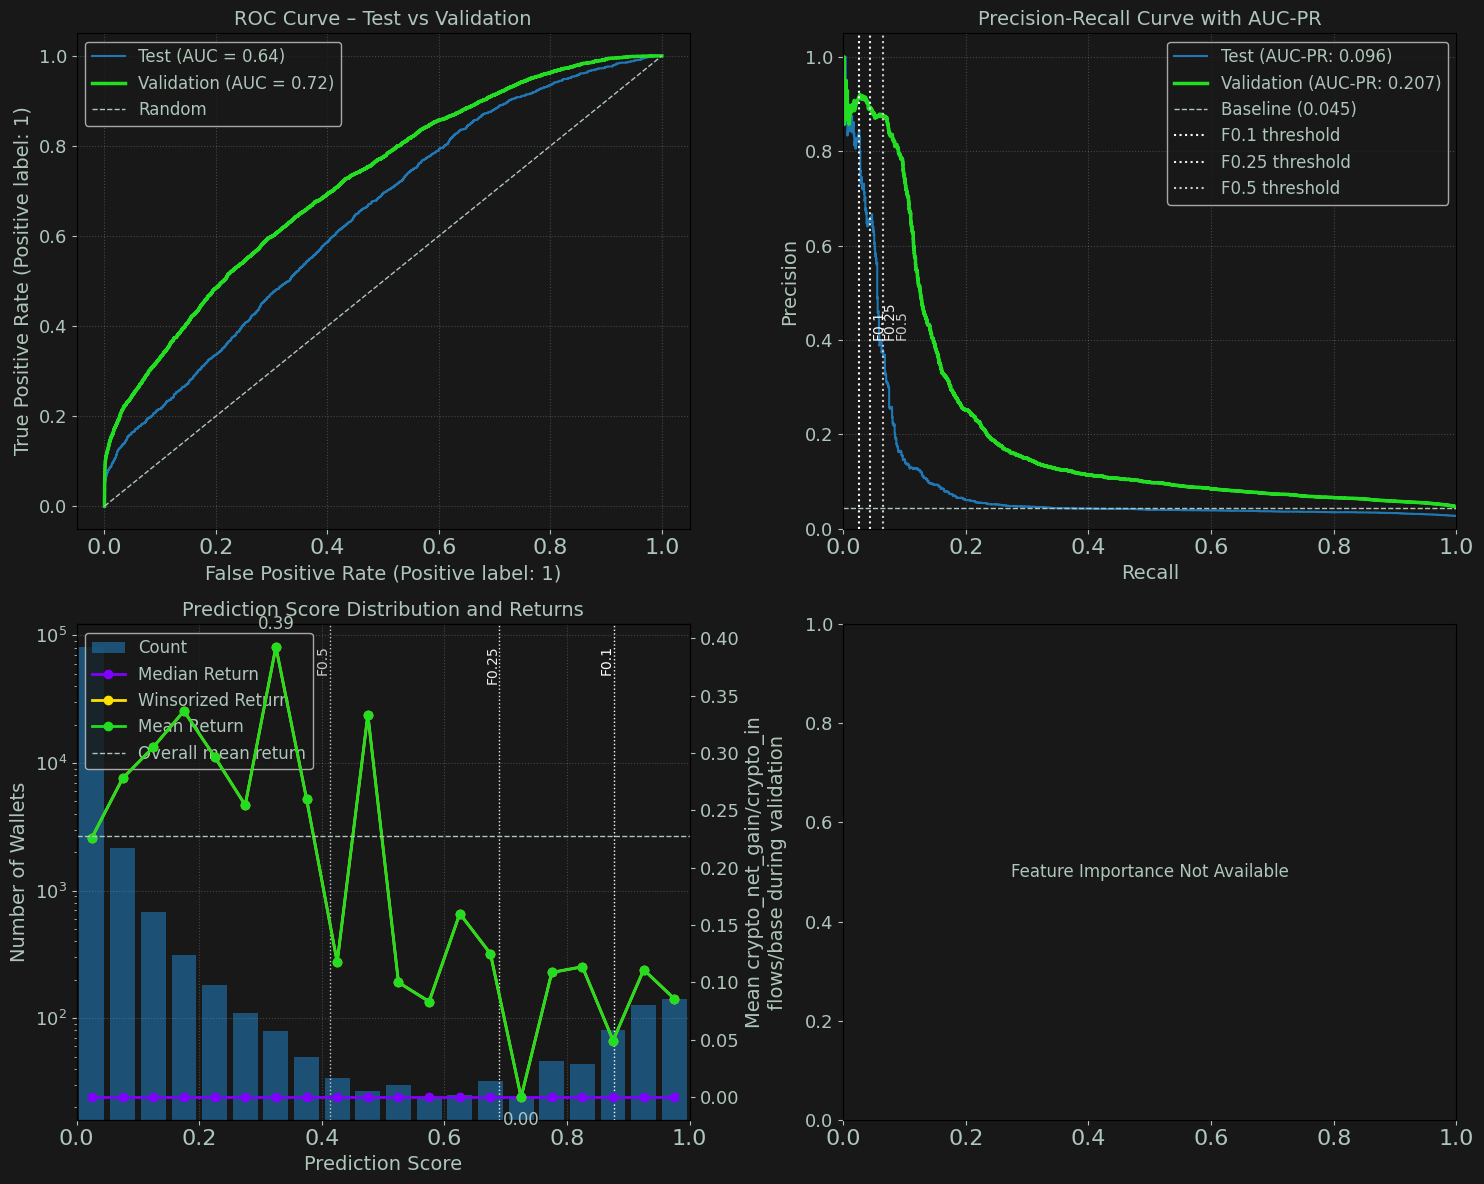

[08/Aug/25 21:47:15] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-10-02
---------------------------------------------------


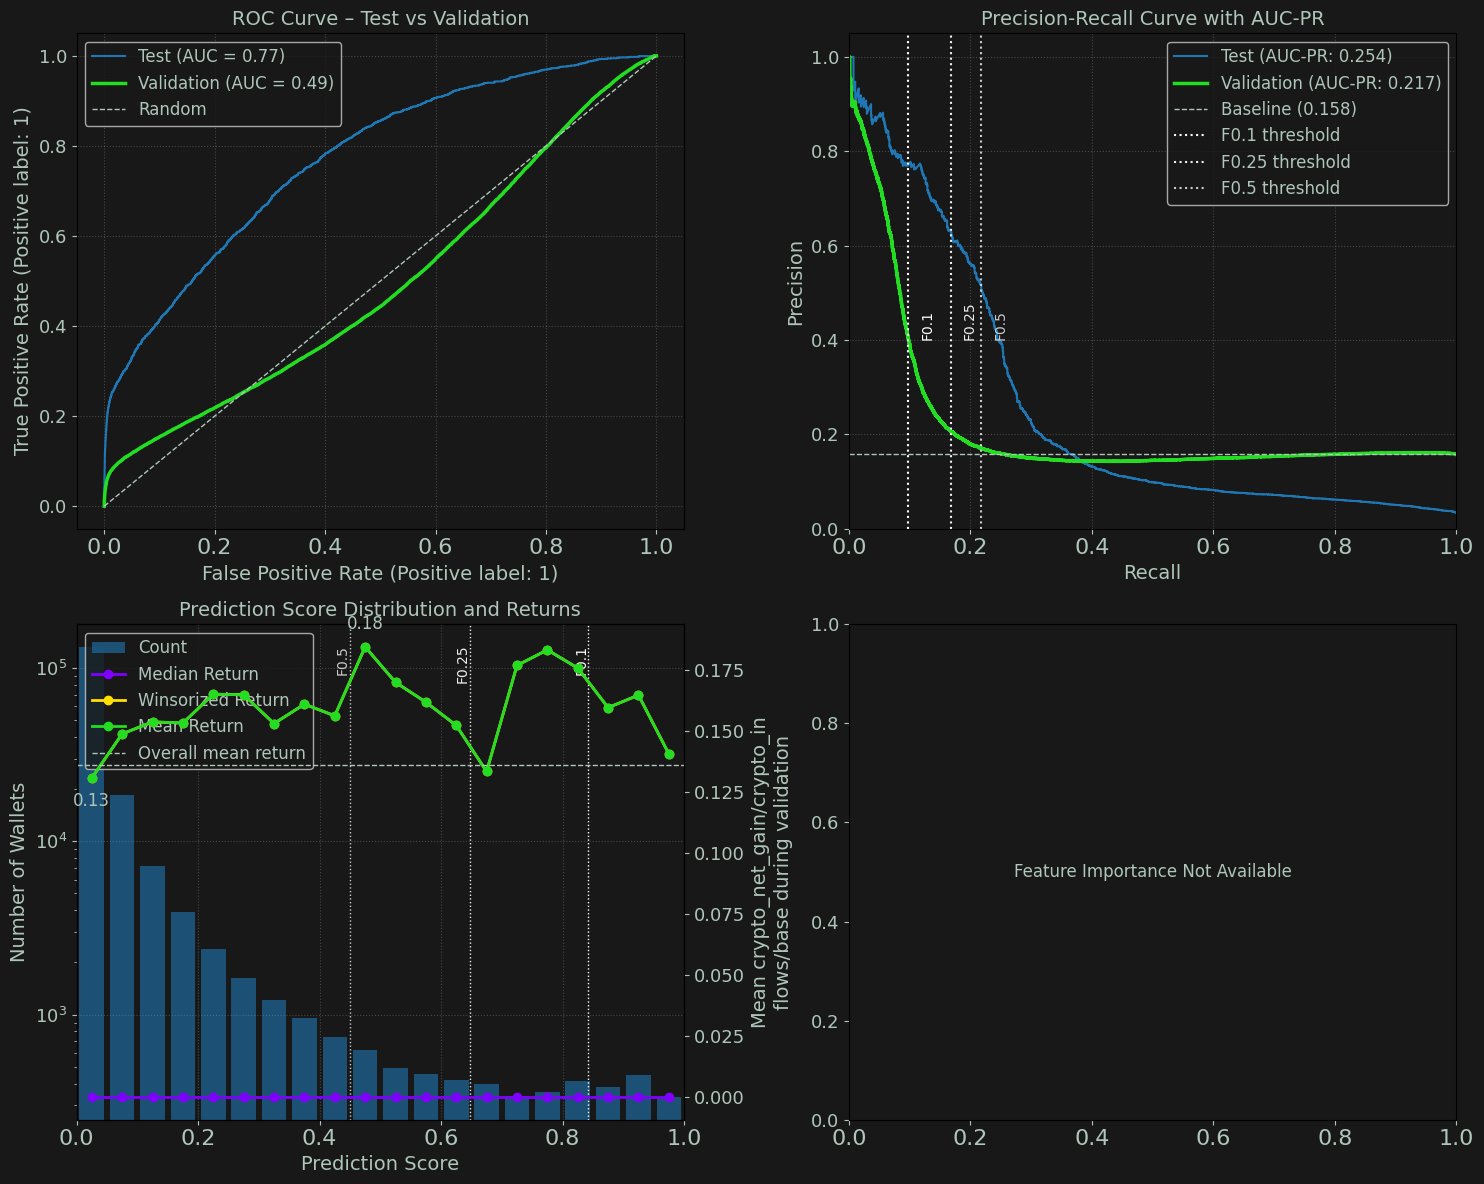

[08/Aug/25 21:47:16] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2024-12-01
---------------------------------------------------


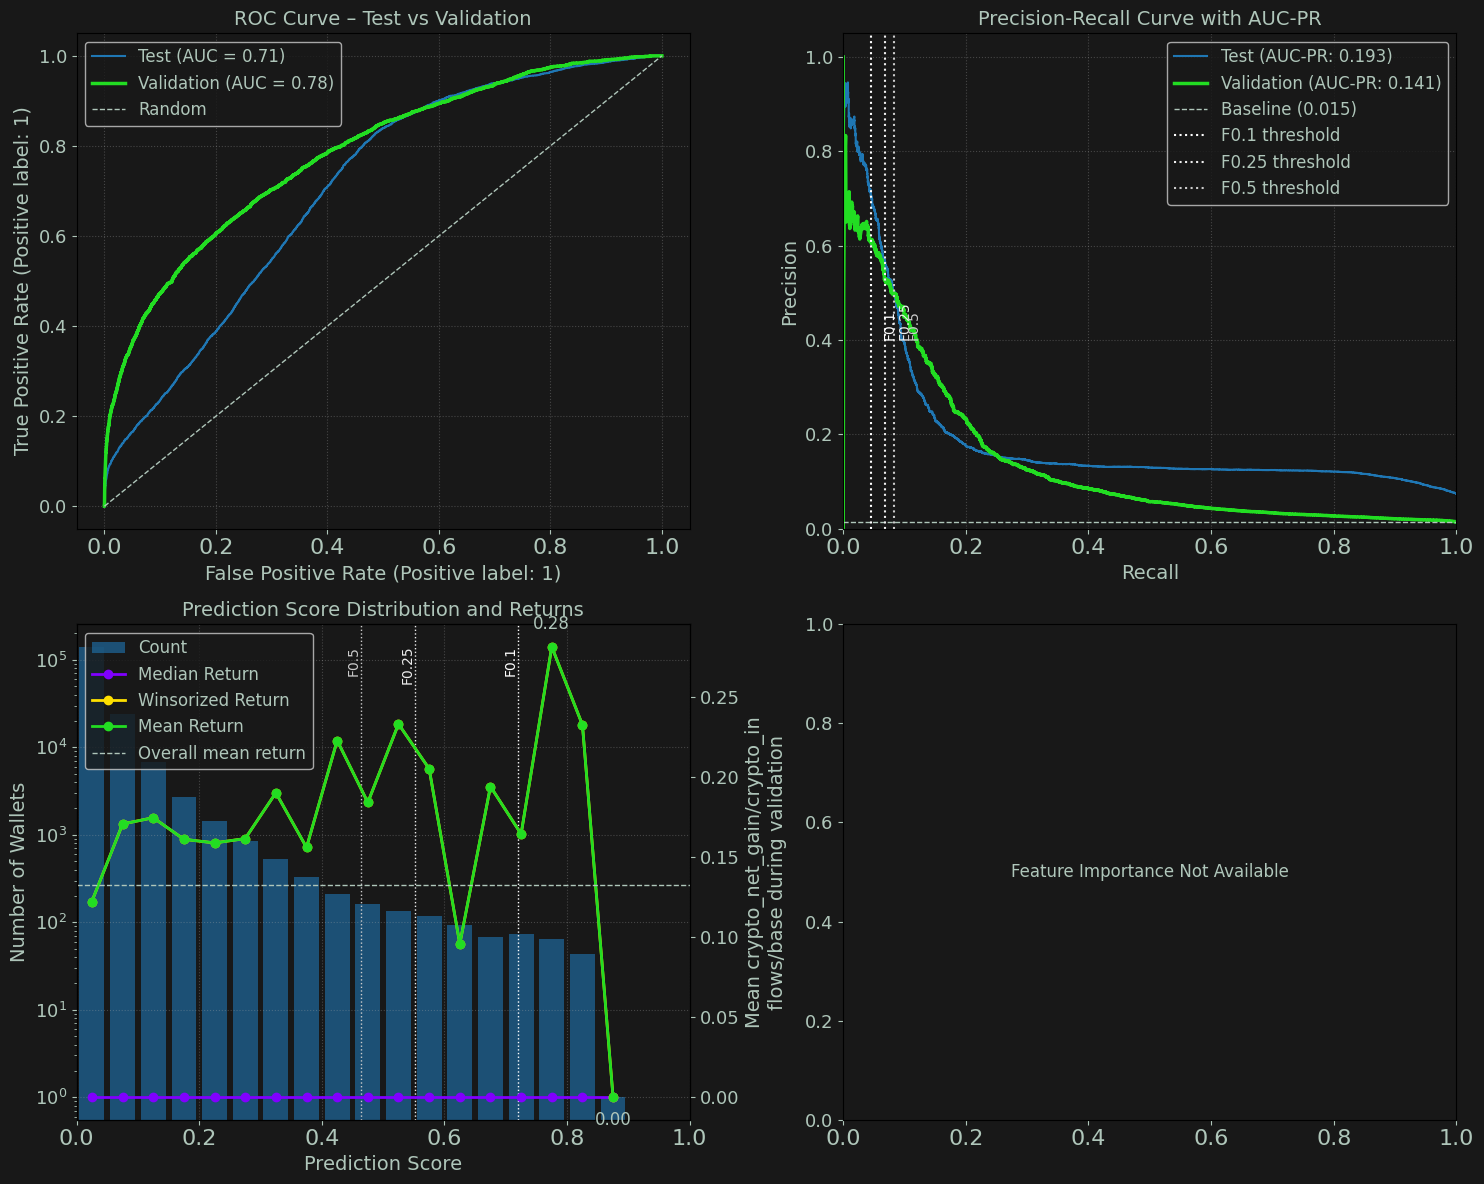

[08/Aug/25 21:47:16] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2025-01-30
---------------------------------------------------


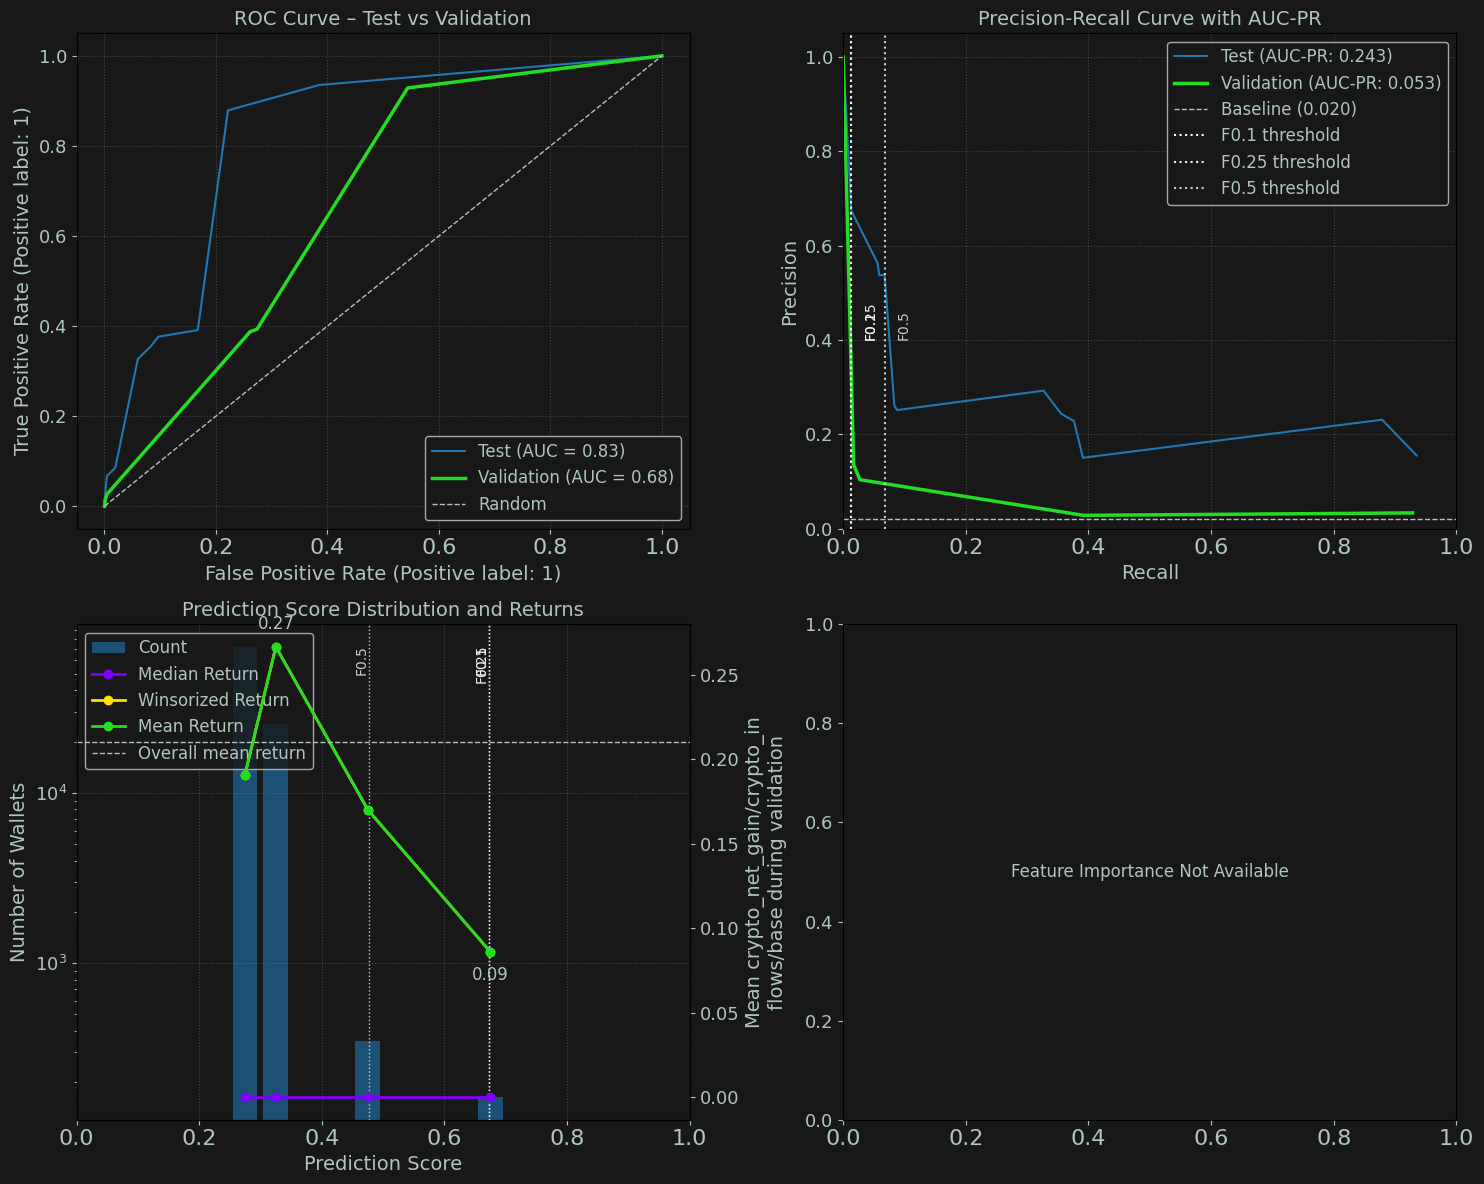

[08/Aug/25 21:47:17] INFO [1419046485.<module>:4] 
Performance over 90 days starting 2025-03-31
---------------------------------------------------


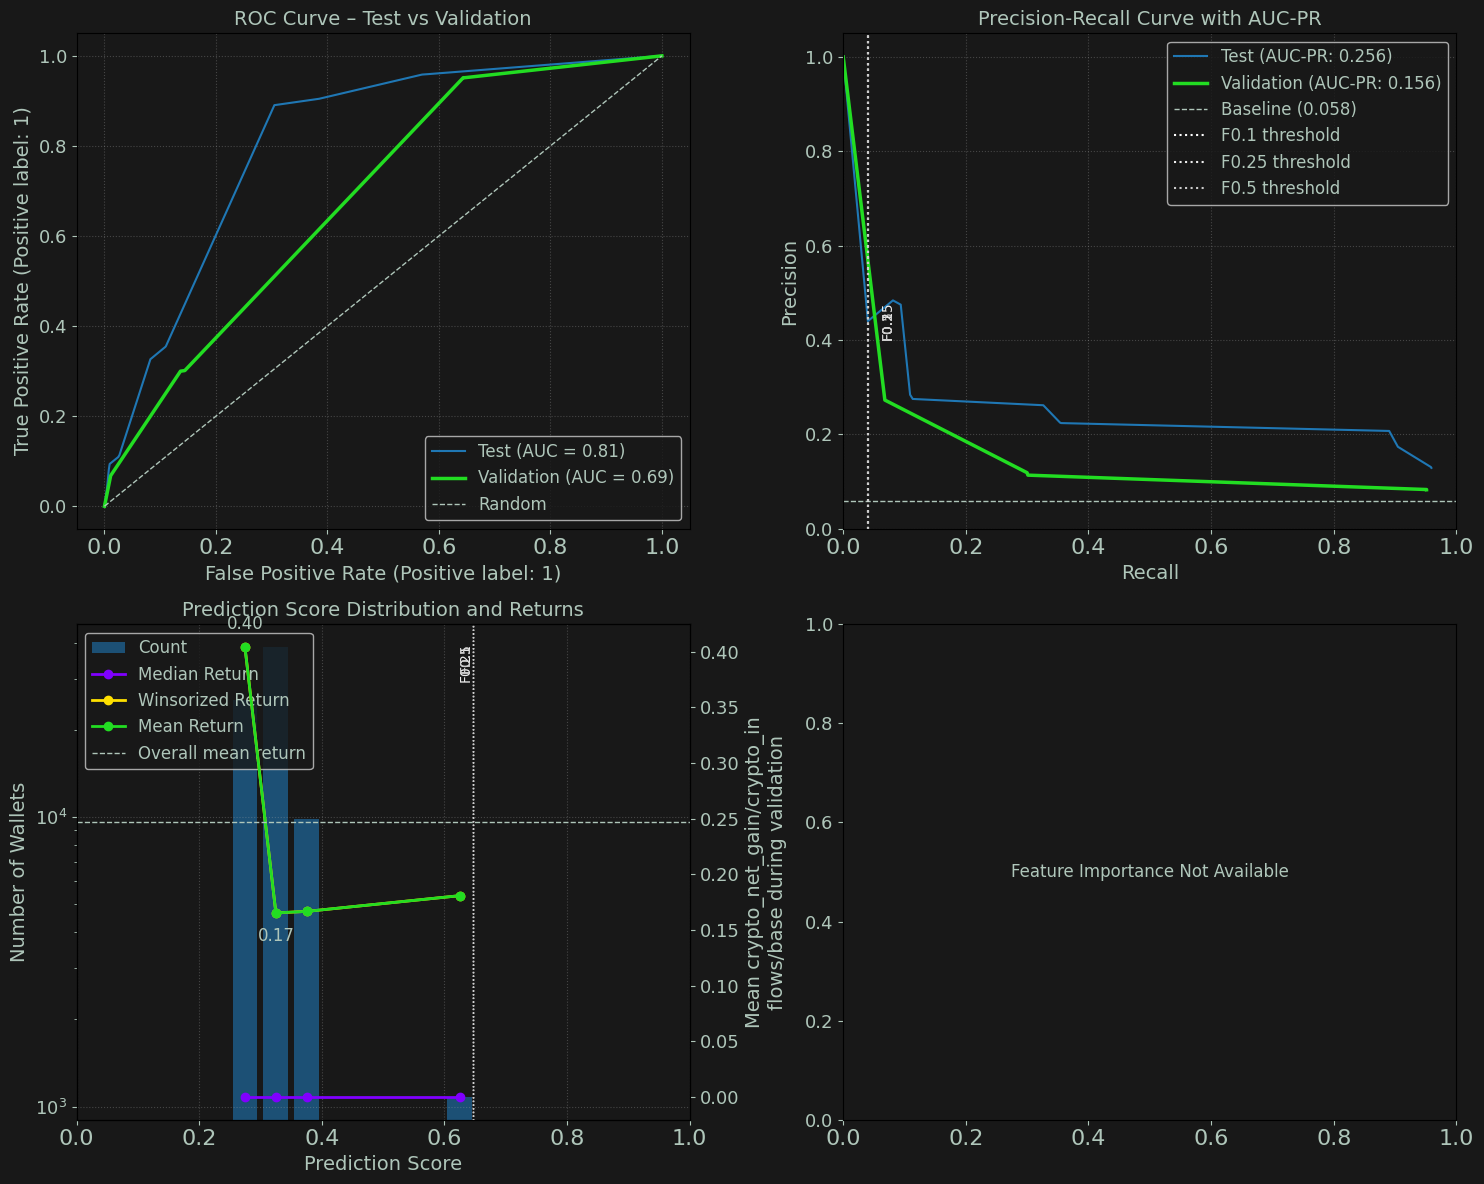

In [98]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%m%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%m-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    evaluators[e].plot_wallet_evaluation()
    # evaluators[e].summary_report()


In [85]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%M%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%M-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    # evaluators[e].plot_wallet_evaluation()
    evaluators[e].summary_report()


[08/Aug/25 21:33:08] INFO [2155157790.<module>:4] 
Performance over 90 days starting 2023-04-07
---------------------------------------------------


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 │   logger.info(f"\nPerformance over 90 days starting {val_start}"                           │
│   5 │   │   │   │   "\n---------------------------------------------------")                     │
│   6 │   # evaluators[e].plot_wallet_evaluation()                                                 │
│ ❱ 7 │   evaluators[e].summary_report()                                                           │
│   8                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: list index out of range

In [78]:
for e in evaluators:
    base_start = datetime.strptime(min(sage_wallets_config['training_data']['val_offsets']),'%y%M%d')
    val_start = (base_start + timedelta(days=e)).strftime('%Y-%M-%d')
    logger.info(f"\nPerformance over 90 days starting {val_start}"
                "\n---------------------------------------------------")
    # evaluators[e].plot_wallet_evaluation()
    evaluators[e].summary_report()


[08/Aug/25 21:11:06] INFO [2155157790.<module>:4] 
Performance over 90 days starting 2023-04-07
---------------------------------------------------
[08/Aug/25 21:11:06] INFO [model_evaluation.summary_report:1097] 
Model Performance Summary
Objective: classification
Target: crypto_net_gain/crypto_inflows/base 0.4 to 
ID: s3://wallet-script-models/model-outputs/dda-951-eval-all-v2/sh-120/wscr-dda-951--sh-120-0808-201711/output/model.tar.gz
Test Samples:             4,732
Val Positive Samples:     382 (1.2%)
Number of Features:       231

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.668  |  0.832
Val Accuracy:               0.988  |  0.972
Val Precision:              0.000  |  0.857
Val Recall:                 0.000  |  0.043
Val F1 Score:               0.000  |  0.083

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |    n/a |   0.012 |   0.0

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

workflow_orch.predict_all_epoch_shifts()

### evaluate all epoch_shifts

In [ ]:
evaluators[-60].summary_report()

In [ ]:
for e in evaluators:
    evaluators[e].plot_wallet_evaluation()


In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
evaluators = workflow_orch.build_all_epoch_shift_evaluators()
for e in evaluators:
    evaluators[e].plot_wallet_evaluation()


In [ ]:
evaluators


#### predict and filter data by epoch_shift

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

# Create modeler with epoch_shift as the date_suffix
shift_s3_uris = {f'sh{epoch_shift}': s3_uris['concat']}
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix=f'sh{epoch_shift}',
    s3_uris=shift_s3_uris,
    override_approvals=None
)

# Load the existing concatenated model
model_info = concat_modeler.load_existing_model(epoch_shift=epoch_shift)

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

epoch_shift = sage_wallets_config['training_data']['epoch_shifts'][0]

date_suffix = f'sh{epoch_shift}'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
    epoch_shift
)

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


### Single Model Sequence

#### train

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
concat_uris = workflow_orch.upload_concatenated_training_data(overwrite_existing=False)
modeling_results = workflow_orch.train_concatenated_offsets_model(concat_uris)

#### evaluate HPO outcomes

In [ ]:
player = u.AmbientPlayer()
player.stop_all_players()

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

workflow_orch = wo.WalletWorkflowOrchestrator(
    sage_wallets_config,
    sage_wallets_modeling_config
)
workflow_orch.get_hpo_results('concat')

In [ ]:
# Get the best hyperparameters
best_params = modeling_results['tuner'].best_training_job()

# Or more detailed info
analytics = modeling_results['tuner'].analytics()
best_job_df = analytics.dataframe()

# The best parameters are in the hyperparameters columns
print(best_params)
print(best_job_df.loc[0, ['eta', 'max_depth', 'subsample', 'FinalObjectiveValue']])

#### load existing model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

# Load S3 URIs
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris(['concat'])

# Create modeler with 'concat' as the date_suffix
concat_modeler = wm.WalletModeler(
    wallets_config=sage_wallets_config,
    modeling_config=sage_wallets_modeling_config,
    date_suffix='concat',
    s3_uris=s3_uris,
    override_approvals=None
)

# Step 2: Load the existing concatenated model
model_info = concat_modeler.load_existing_model(modeling_results['model_uri'])


In [ ]:
model_info

#### predict

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

pred_results = concat_modeler.batch_predict_test_and_val()

#### evaluate

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')

date_suffix = 'concat'
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_test      = sime.load_concatenated_y('test', sage_wallets_config, sage_wallets_modeling_config)
y_val_pred  = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)
y_val       = sime.load_concatenated_y('val', sage_wallets_config, sage_wallets_modeling_config)


target_var = sage_wallets_modeling_config['target']['target_var']
y_test.columns = [target_var]
y_val.columns = [target_var]

# Single function call for complete evaluation
evaluator = sime.create_concatenated_sagemaker_evaluator(
    sage_wallets_config,
    sage_wallets_modeling_config,
    model_info['model_uri'],
    y_test_pred,
    y_test,
    y_val_pred,
    y_val,
)

In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 all history
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr 0.4 mktcap 20M-4B
logger.info(modeling_results['model_uri'])
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
# u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, inflows $5k
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


In [ ]:
# auc pr mktcap 20M-4B, z score 1.5
evaluator.summary_report()
evaluator.plot_wallet_evaluation()
u.notify('soft_twinkle_musical')


## Temporal cv model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '241101',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
workflow_orch.load_all_training_data(date_suffixes)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

In [ ]:
sm.train_temporal_cv_script_model(sage_wallets_config,sage_wallets_modeling_config,cv_s3_uri)

### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = ucv.load_sage_wallets_config('../config/sage_wallets_config.yaml')
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config('../config/sage_wallets_modeling_config.yaml')


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [ ]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

In [ ]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [ ]:
evaluator.y_validation

In [ ]:
evaluator.y_validation_pred_proba

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable